# Construct datasets (Friedman1)

In [185]:
from sklearn.datasets import make_friedman1
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler, GridSampler, RandomSampler
import math
'''
num_row = 1000
num_col = 1000
noise_val = 10

frd = sklearn.datasets.make_friedman1(n_samples=num_row, n_features=num_col, noise=noise_val, random_state=1)
dtrain = pd.DataFrame(data=frd[1], columns=['y'])
dtrain = pd.concat([dtrain,pd.DataFrame(frd[0], columns=range(1,num_col+1))], axis=1)
frd = sklearn.datasets.make_friedman1(n_samples=num_row, n_features=num_col, noise=noise_val, random_state=12)
dtest = pd.DataFrame(data=frd[1], columns=['y'])
dtest = pd.concat([dtest,pd.DataFrame(frd[0], columns=range(1,num_col+1))], axis=1)
xtrain = dtrain[dtrain.columns[1:len(dtrain.columns)]]
ytrain = dtrain[dtrain.columns[0:1]]
xtest = dtest[dtest.columns[1:len(dtest.columns)]]
ytest = dtest[dtest.columns[0:1]]
'''

"\nnum_row = 1000\nnum_col = 1000\nnoise_val = 10\n\nfrd = sklearn.datasets.make_friedman1(n_samples=num_row, n_features=num_col, noise=noise_val, random_state=1)\ndtrain = pd.DataFrame(data=frd[1], columns=['y'])\ndtrain = pd.concat([dtrain,pd.DataFrame(frd[0], columns=range(1,num_col+1))], axis=1)\nfrd = sklearn.datasets.make_friedman1(n_samples=num_row, n_features=num_col, noise=noise_val, random_state=12)\ndtest = pd.DataFrame(data=frd[1], columns=['y'])\ndtest = pd.concat([dtest,pd.DataFrame(frd[0], columns=range(1,num_col+1))], axis=1)\nxtrain = dtrain[dtrain.columns[1:len(dtrain.columns)]]\nytrain = dtrain[dtrain.columns[0:1]]\nxtest = dtest[dtest.columns[1:len(dtest.columns)]]\nytest = dtest[dtest.columns[0:1]]\n"

In [2]:
# create multiple datasets with different noises and sizes
# num_row = [100, 500, 1000], num_col = [100, 500, 1000], noise = [1, 5, 10]
num_datasets = 27
num_row = [100, 500, 1000]
num_col = [100, 500, 1000]
noise_val = [1, 5, 10]
comb_list = []
for i in num_row:
    for j in num_col:
        for k in noise_val:
            comb_list.append((i, j, k))
num_datasets = len(comb_list)            
df_list = []
dmat_list = []
for n in range(len(comb_list)):
    frd1 = make_friedman1(n_samples=comb_list[n][0], n_features=comb_list[n][1],
                                           noise=comb_list[n][2], random_state=123)
    df = pd.DataFrame(data=frd1[1], columns=['y'])
    df = pd.concat([df, pd.DataFrame(frd1[0], columns=range(1,comb_list[n][1]+1))], axis=1)
    df_list.append(df) 
    dmat = xgb.DMatrix(frd1[0], label=frd1[1])
    dmat_list.append(dmat) 

# Random Forest using default values

In [9]:
# Define the parameter search space
dval = {
    'n_estimators': 100, # "num.trees": 500 / "n_estimators": 100
    'criterion': 'mse',
    'bootstrap': True, # replace
    'max_samples': None, # sample.fraction
    'max_features': 'sqrt', ### "mtry": "sqrt" / "max_features": "auto" ###
    'min_samples_leaf': 1, # "min.node.size" default: 5 / "min_samples_leaf": 1
    'n_jobs': -1}
# Fit the model to each dataset
def_result = pd.DataFrame(columns=['rf_rmse'])
mlist = []
mod = RandomForestRegressor(**dval)
for i in range(num_datasets):
    num_col = df_list[i].shape[1]
    yvec = df_list[i].iloc[:,0:1].values.ravel()
    rmse = cross_val_score(mod, df_list[i].iloc[:,1:num_col], yvec, 
                           scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
    mlist.append(abs(rmse).mean())
def_result['rf_rmse'] = mlist

In [10]:
def_result.head

<bound method NDFrame.head of       rf_rmse
0    4.218308
1    6.536200
2   11.037170
3    4.765139
4    7.324557
5   11.380439
6    4.696653
7    6.127405
8    9.699046
9    3.578173
10   5.952702
11  10.199506
12   4.355566
13   6.656529
14  11.356975
15   4.584903
16   6.819671
17  11.018432
18   3.341211
19   6.040078
20  10.607756
21   4.202412
22   6.388458
23  10.743064
24   4.421351
25   6.824538
26  11.219579>

In [16]:
def_result["rf_rmse"].mean()

7.188734218730979

# XGBOOST using default values

In [13]:
# Define the parameter search space
dval = {
    "booster": "gbtree",
    "lambda": 1,
    "alpha": 0,
    "eta": 0.3,
    "subsample": 1,
    "max_depth": 6,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1
}
n_boost = 10
# Fit the model to each dataset
mlist = []
for i in range(num_datasets):
    bst = xgb.cv(dval, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
    mlist.append(bst.iloc[len(bst.index)-1, 2])
def_result["xgb_rmse"] = mlist

In [14]:
def_result

,rf_rmse,xgb_rmse
0,4.218308,3.485980
1,6.536200,6.950154
2,11.037170,11.921989
3,4.765139,4.610960
4,7.324557,7.602259
5,11.380439,13.823878
6,4.696653,3.441053
7,6.127405,5.706423
8,9.699046,11.041093
9,3.578173,2.613650


In [15]:
def_result["xgb_rmse"].mean()

6.960065807407409

In [17]:
# Save the result
def_result.to_csv("result of default values.csv", index=False)

# Tunability of a specific hyperparameter

## Random Forest

### 1. n_estimators (number of trees)

In [24]:
param_list = [1, *range(10,510,10)]
def objective(trial):
    mlist = []
    param = {
        "n_estimators": trial.suggest_categorical("n_estimators", param_list),
        'criterion': 'mse',
        'bootstrap': True, # replace
        'max_samples': None, # sample.fraction
        'max_features': 'sqrt', ### "mtry": "sqrt" / "max_features": "auto" ###
        'min_samples_leaf': 1, # "min.node.size" default: 5 / "min_samples_leaf": 1
        'n_jobs': -1
    }
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                               scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# define grid points
search_space = {'n_estimators': param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 51


In [25]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res1 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 17:14:58,973] Finished trial#0 with value: 7.152401787749707 with parameters: {'n_estimators': 390}. Best is trial#0 with value: 7.152401787749707.
[I 2020-07-23 17:15:16,464] Finished trial#1 with value: 7.191784642291056 with parameters: {'n_estimators': 110}. Best is trial#0 with value: 7.152401787749707.
[I 2020-07-23 17:16:01,317] Finished trial#2 with value: 7.1642932378439514 with parameters: {'n_estimators': 370}. Best is trial#0 with value: 7.152401787749707.
[I 2020-07-23 17:16:20,995] Finished trial#3 with value: 7.1665200049020745 with parameters: {'n_estimators': 150}. Best is trial#0 with value: 7.152401787749707.
[I 2020-07-23 17:16:43,647] Finished trial#4 with value: 7.181507183258573 with parameters: {'n_estimators': 180}. Best is tria

In [26]:
res1.head(10)

,number,value,datetime_start,datetime_complete,duration,params_n_estimators,system_attrs_grid_id,system_attrs_search_space,state
0,0,7.152402,2020-07-23 17:14:08.427536,2020-07-23 17:14:58.973099,00:00:50.545563,390,39,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
1,1,7.191785,2020-07-23 17:14:58.976364,2020-07-23 17:15:16.463868,00:00:17.487504,110,11,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
2,2,7.164293,2020-07-23 17:15:16.467208,2020-07-23 17:16:01.316864,00:00:44.849656,370,37,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
3,3,7.166520,2020-07-23 17:16:01.320222,2020-07-23 17:16:20.995021,00:00:19.674799,150,15,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
4,4,7.181507,2020-07-23 17:16:20.998483,2020-07-23 17:16:43.647246,00:00:22.648763,180,18,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
5,5,7.150494,2020-07-23 17:16:43.650757,2020-07-23 17:17:20.083205,00:00:36.432448,310,31,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
6,6,7.197599,2020-07-23 17:17:20.086302,2020-07-23 17:17:31.025391,00:00:10.939089,60,6,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
7,7,7.191650,2020-07-23 17:17:31.029139,2020-07-23 17:17:42.311354,00:00:11.282215,70,7,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
8,8,7.151508,2020-07-23 17:17:42.314546,2020-07-23 17:18:28.223217,00:00:45.908671,410,41,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE
9,9,7.165018,2020-07-23 17:18:28.226468,2020-07-23 17:19:10.307651,00:00:42.081183,360,36,"{'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...",COMPLETE


In [27]:
idx_min = res1["value"].idxmin
res1.iloc[idx_min,:]

number                                                                      14
value                                                                  7.14898
datetime_start                                      2020-07-23 17:20:57.687983
datetime_complete                                   2020-07-23 17:21:49.729381
duration                                                0 days 00:00:52.041398
params_n_estimators                                                        470
system_attrs_grid_id                                                        47
system_attrs_search_space    {'n_estimators': [1, 10, 20, 30, 40, 50, 60, 7...
state                                                                 COMPLETE
Name: 14, dtype: object

In [43]:
res1.to_csv("rf_n_estimators.csv", index=False)

### 2. bootstrap (replace)

In [38]:
param_list = [True, False]
def objective(trial):
    mlist = []
    param = {
        "n_estimators": 100,
        'criterion': 'mse',
        'bootstrap': trial.suggest_categorical('bootstrap', param_list), # replace
        'max_features': 'sqrt', ### "mtry": "sqrt" / "max_features": "auto" ###
        'min_samples_leaf': 1, # "min.node.size" default: 5 / "min_samples_leaf": 1
        'n_jobs': -1
    }
    if param["bootstrap"] == True:
        param["max_samples"] = None
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                               scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# define grid points
search_space = {'bootstrap': param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 2


In [39]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res2 = study.trials_dataframe()

[I 2020-07-23 17:59:09,185] Finished trial#0 with value: 7.179147586896003 with parameters: {'bootstrap': True}. Best is trial#0 with value: 7.179147586896003.
[I 2020-07-23 17:59:26,348] Finished trial#1 with value: 7.144892911120967 with parameters: {'bootstrap': False}. Best is trial#1 with value: 7.144892911120967.


In [40]:
res2

,number,value,datetime_start,datetime_complete,duration,params_bootstrap,system_attrs_grid_id,system_attrs_search_space,state
0,0,7.179148,2020-07-23 17:58:51.524880,2020-07-23 17:59:09.184915,00:00:17.660035,True,1,"{'bootstrap': [False, True]}",COMPLETE
1,1,7.144893,2020-07-23 17:59:09.188106,2020-07-23 17:59:26.348660,00:00:17.160554,False,0,"{'bootstrap': [False, True]}",COMPLETE


In [41]:
idx_min = res2["value"].idxmin
res2.iloc[idx_min,:]

number                                                  1
value                                             7.14489
datetime_start                 2020-07-23 17:59:09.188106
datetime_complete              2020-07-23 17:59:26.348660
duration                           0 days 00:00:17.160554
params_bootstrap                                    False
system_attrs_grid_id                                    0
system_attrs_search_space    {'bootstrap': [False, True]}
state                                            COMPLETE
Name: 1, dtype: object

In [44]:
res2.to_csv("rf_bootstrap.csv", index=False)

### 3. max_samples (sample.fraction)

In [45]:
param_list = [i/10 for i in range(1,10)]
param_list.append(0.99)
def objective(trial):
    mlist = []
    param = {
        "n_estimators": 100,
        'criterion': 'mse',
        'bootstrap': True, # replace
        'max_samples': trial.suggest_categorical("max_samples", param_list),
        'max_features': "sqrt", ### "mtry": "sqrt" --better / "max_features": "auto" ###
        'min_samples_leaf': 1, # "min.node.size" default: 5 / "min_samples_leaf": 1
        'n_jobs': -1
    }
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                               scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# define grid points
search_space = {'max_samples': param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 10


In [46]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res3 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 18:02:58,984] Finished trial#0 with value: 7.203243231966116 with parameters: {'max_samples': 0.7}. Best is trial#0 with value: 7.203243231966116.
[I 2020-07-23 18:03:09,544] Finished trial#1 with value: 7.35694914913272 with parameters: {'max_samples': 0.2}. Best is trial#0 with value: 7.203243231966116.
[I 2020-07-23 18:03:23,422] Finished trial#2 with value: 7.194992715714807 with parameters: {'max_samples': 0.9}. Best is trial#2 with value: 7.194992715714807.
[I 2020-07-23 18:03:33,347] Finished trial#3 with value: 7.43187135985108 with parameters: {'max_samples': 0.1}. Best is trial#2 with value: 7.194992715714807.
[I 2020-07-23 18:03:44,810] Finished trial#4 with value: 7.268909188810238 with parameters: {'max_samples': 0.4}. Best is trial#2 with 

In [47]:
res3

,number,value,datetime_start,datetime_complete,duration,params_max_samples,system_attrs_grid_id,system_attrs_search_space,state
0,0,7.203243,2020-07-23 18:02:46.322111,2020-07-23 18:02:58.983815,00:00:12.661704,0.70,6,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
1,1,7.356949,2020-07-23 18:02:58.986494,2020-07-23 18:03:09.543765,00:00:10.557271,0.20,1,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
2,2,7.194993,2020-07-23 18:03:09.546485,2020-07-23 18:03:23.422147,00:00:13.875662,0.90,8,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
3,3,7.431871,2020-07-23 18:03:23.425267,2020-07-23 18:03:33.346723,00:00:09.921456,0.10,0,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
4,4,7.268909,2020-07-23 18:03:33.350397,2020-07-23 18:03:44.809811,00:00:11.459414,0.40,3,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
5,5,7.251427,2020-07-23 18:03:44.813155,2020-07-23 18:03:57.401271,00:00:12.588116,0.60,5,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
6,6,7.315520,2020-07-23 18:03:57.404531,2020-07-23 18:04:08.787391,00:00:11.382860,0.30,2,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
7,7,7.241209,2020-07-23 18:04:08.790645,2020-07-23 18:04:21.700089,00:00:12.909444,0.50,4,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
8,8,7.210314,2020-07-23 18:04:21.702668,2020-07-23 18:04:36.916972,00:00:15.214304,0.80,7,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE
9,9,7.178239,2020-07-23 18:04:36.920237,2020-07-23 18:04:52.662405,00:00:15.742168,0.99,9,"{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...",COMPLETE


In [48]:
idx_min = res3["value"].idxmin
res3.iloc[idx_min,:]

number                                                                       9
value                                                                  7.17824
datetime_start                                      2020-07-23 18:04:36.920237
datetime_complete                                   2020-07-23 18:04:52.662405
duration                                                0 days 00:00:15.742168
params_max_samples                                                        0.99
system_attrs_grid_id                                                         9
system_attrs_search_space    {'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,...
state                                                                 COMPLETE
Name: 9, dtype: object

In [49]:
res3.to_csv("rf_max_samples.csv", index=False)

### 4. max_features (mtry)

In [50]:
### This is very time-consuming!!!!!!!!!!!!!
param_list = ["sqrt", "auto", "log2"]
def objective(trial):
    mlist = []
    param = {
        "n_estimators": 100,
        'criterion': 'mse',
        'bootstrap': True, # replace
        'max_samples': None,
        'max_features': trial.suggest_categorical('max_features', ["sqrt", "auto", "log2"]), ### "mtry": "sqrt" --better / "max_features": "auto" ###
        'min_samples_leaf': 1, # "min.node.size" default: 5 / "min_samples_leaf": 1
        'n_jobs': -1
    }
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                               scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# define grid points
search_space = {'max_features': param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 3


In [51]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res4 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 18:07:10,021] Finished trial#0 with value: 6.591600669261134 with parameters: {'max_features': 'auto'}. Best is trial#0 with value: 6.591600669261134.
[I 2020-07-23 18:07:24,504] Finished trial#1 with value: 7.186650143907176 with parameters: {'max_features': 'sqrt'}. Best is trial#0 with value: 6.591600669261134.
[I 2020-07-23 18:07:36,065] Finished trial#2 with value: 7.337745430643744 with parameters: {'max_features': 'log2'}. Best is trial#0 with value: 6.591600669261134.


In [52]:
res4

,number,value,datetime_start,datetime_complete,duration,params_max_features,system_attrs_grid_id,system_attrs_search_space,state
0,0,6.591601,2020-07-23 18:04:52.730432,2020-07-23 18:07:10.021473,00:02:17.291041,auto,0,"{'max_features': ['auto', 'log2', 'sqrt']}",COMPLETE
1,1,7.186650,2020-07-23 18:07:10.024684,2020-07-23 18:07:24.504159,00:00:14.479475,sqrt,2,"{'max_features': ['auto', 'log2', 'sqrt']}",COMPLETE
2,2,7.337745,2020-07-23 18:07:24.507398,2020-07-23 18:07:36.064754,00:00:11.557356,log2,1,"{'max_features': ['auto', 'log2', 'sqrt']}",COMPLETE


In [53]:
idx_min = res4["value"].idxmin
res4.iloc[idx_min,:]

number                                                                0
value                                                            6.5916
datetime_start                               2020-07-23 18:04:52.730432
datetime_complete                            2020-07-23 18:07:10.021473
duration                                         0 days 00:02:17.291041
params_max_features                                                auto
system_attrs_grid_id                                                  0
system_attrs_search_space    {'max_features': ['auto', 'log2', 'sqrt']}
state                                                          COMPLETE
Name: 0, dtype: object

In [54]:
res4.to_csv("rf_max_features.csv", index=False)

### 5. min_samples_leaf (min.node.size)

In [55]:
param_list = [i/10 for i in range(1, 6)]
param_list.append(1)
def objective(trial):
    mlist = []
    param = {
        "n_estimators": 100,
        'criterion': 'mse',
        'bootstrap': True, # replace
        'max_samples': None,
        'max_features': "sqrt", ### "mtry": "sqrt" --better / "max_features": "auto" ###
        'min_samples_leaf': trial.suggest_categorical("min_samples_leaf", param_list), # "min.node.size" default: 5 / "min_samples_leaf": 1
        'n_jobs': -1
    }
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                               scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# define grid points
search_space = {'min_samples_leaf': param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 6


In [56]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res5 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 18:07:43,983] Finished trial#0 with value: 7.553613135980026 with parameters: {'min_samples_leaf': 0.5}. Best is trial#0 with value: 7.553613135980026.
[I 2020-07-23 18:07:51,838] Finished trial#1 with value: 7.553691465646784 with parameters: {'min_samples_leaf': 0.4}. Best is trial#0 with value: 7.553613135980026.
[I 2020-07-23 18:08:01,896] Finished trial#2 with value: 7.350617521481009 with parameters: {'min_samples_leaf': 0.1}. Best is trial#2 with value: 7.350617521481009.
[I 2020-07-23 18:08:15,905] Finished trial#3 with value: 7.185358058758812 with parameters: {'min_samples_leaf': 1}. Best is trial#3 with value: 7.185358058758812.
[I 2020-07-23 18:08:25,848] Finished trial#4 with value: 7.436399679460474 with parameters: {'min_samples_leaf': 0.

In [57]:
res5

,number,value,datetime_start,datetime_complete,duration,params_min_samples_leaf,system_attrs_grid_id,system_attrs_search_space,state
0,0,7.553613,2020-07-23 18:07:36.125742,2020-07-23 18:07:43.983517,00:00:07.857775,0.5,4,"{'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
1,1,7.553691,2020-07-23 18:07:43.986745,2020-07-23 18:07:51.838083,00:00:07.851338,0.4,3,"{'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
2,2,7.350618,2020-07-23 18:07:51.841303,2020-07-23 18:08:01.896290,00:00:10.054987,0.1,0,"{'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
3,3,7.185358,2020-07-23 18:08:01.899269,2020-07-23 18:08:15.905378,00:00:14.006109,1.0,5,"{'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
4,4,7.436400,2020-07-23 18:08:15.908675,2020-07-23 18:08:25.847705,00:00:09.939030,0.2,1,"{'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
5,5,7.470213,2020-07-23 18:08:25.850963,2020-07-23 18:08:34.387853,00:00:08.536890,0.3,2,"{'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE


In [58]:
idx_min = res5["value"].idxmin
res5.iloc[idx_min,:]

number                                                                       3
value                                                                  7.18536
datetime_start                                      2020-07-23 18:08:01.899269
datetime_complete                                   2020-07-23 18:08:15.905378
duration                                                0 days 00:00:14.006109
params_min_samples_leaf                                                      1
system_attrs_grid_id                                                         5
system_attrs_search_space    {'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,...
state                                                                 COMPLETE
Name: 3, dtype: object

In [59]:
res5.to_csv("rf_min_samples_leaf.csv", index=False)

## XGBoost

### 1. lambda

In [92]:
param_list = [2**(-9) * 2 ** i for i in range(len(range(-9,11,1)))]
param_list.append(0)
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": trial.suggest_categorical("lambda", param_list),
        "alpha": 0,
        "eta": 0.3,
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"lambda": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 21


In [93]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res1 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 19:54:44,151] Finished trial#0 with value: 7.354702385185184 with parameters: {'lambda': 0.00390625}. Best is trial#0 with value: 7.354702385185184.
[I 2020-07-23 19:54:50,043] Finished trial#1 with value: 7.198162377777777 with parameters: {'lambda': 0.0625}. Best is trial#1 with value: 7.198162377777777.
[I 2020-07-23 19:54:56,099] Finished trial#2 with value: 7.341602303703702 with parameters: {'lambda': 0.001953125}. Best is trial#1 with value: 7.198162377777777.
[I 2020-07-23 19:55:04,113] Finished trial#3 with value: 7.126744511111111 with parameters: {'lambda': 0.125}. Best is trial#3 with value: 7.126744511111111.
[I 2020-07-23 19:55:10,488] Finished trial#4 with value: 6.946966051851852 with parameters: {'lambda': 4.0}. Best is trial#4 with val

In [147]:
res1.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_lambda,system_attrs_grid_id,system_attrs_search_space,state
4,4,6.946966,2020-07-23 19:55:04.115195,2020-07-23 19:55:10.488454,00:00:06.373259,4.000000,12,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
11,11,6.960066,2020-07-23 19:55:46.196312,2020-07-23 19:55:51.942075,00:00:05.745763,1.000000,10,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
17,17,6.970372,2020-07-23 19:56:21.413896,2020-07-23 19:56:27.203827,00:00:05.789931,2.000000,11,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
8,8,7.044089,2020-07-23 19:55:28.692589,2020-07-23 19:55:34.423222,00:00:05.730633,0.500000,9,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
5,5,7.076976,2020-07-23 19:55:10.490983,2020-07-23 19:55:16.904595,00:00:06.413612,8.000000,13,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
19,19,7.124182,2020-07-23 19:56:33.294459,2020-07-23 19:56:39.264967,00:00:05.970508,0.250000,8,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
18,18,7.125543,2020-07-23 19:56:27.206496,2020-07-23 19:56:33.291846,00:00:06.085350,16.000000,14,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
3,3,7.126745,2020-07-23 19:54:56.101931,2020-07-23 19:55:04.112986,00:00:08.011055,0.125000,7,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
16,16,7.158189,2020-07-23 19:56:15.610871,2020-07-23 19:56:21.411378,00:00:05.800507,32.000000,15,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE
1,1,7.198162,2020-07-23 19:54:44.153082,2020-07-23 19:54:50.042750,00:00:05.889668,0.062500,6,"{'lambda': [0, 0.001953125, 0.00390625, 0.0078...",COMPLETE


In [95]:
idx_min = res1["value"].idxmin
res1.iloc[idx_min,:]

number                                                                       4
value                                                                  6.94697
datetime_start                                      2020-07-23 19:55:04.115195
datetime_complete                                   2020-07-23 19:55:10.488454
duration                                                0 days 00:00:06.373259
params_lambda                                                                4
system_attrs_grid_id                                                        12
system_attrs_search_space    {'lambda': [0, 0.001953125, 0.00390625, 0.0078...
state                                                                 COMPLETE
Name: 4, dtype: object

In [96]:
res1.to_csv("xgb_lambda.csv", index=False)

### 2. alpha

In [97]:
param_list = [2**(-9) * 2 ** i for i in range(len(range(-9,11,1)))]
param_list.append(0)
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": trial.suggest_categorical("alpha", param_list),
        "eta": 0.3,
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"alpha": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 21


In [98]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res2 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 19:56:51,455] Finished trial#0 with value: 10.008363422222224 with parameters: {'alpha': 1024.0}. Best is trial#0 with value: 10.008363422222224.
[I 2020-07-23 19:56:59,031] Finished trial#1 with value: 7.239814325925925 with parameters: {'alpha': 64.0}. Best is trial#1 with value: 7.239814325925925.
[I 2020-07-23 19:57:05,292] Finished trial#2 with value: 8.145229896296293 with parameters: {'alpha': 512.0}. Best is trial#1 with value: 7.239814325925925.
[I 2020-07-23 19:57:12,660] Finished trial#3 with value: 6.95218854814815 with parameters: {'alpha': 0.125}. Best is trial#3 with value: 6.95218854814815.
[I 2020-07-23 19:57:20,035] Finished trial#4 with value: 7.013363577777778 with parameters: {'alpha': 2.0}. Best is trial#3 with value: 6.95218854814

In [148]:
res2.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_alpha,system_attrs_grid_id,system_attrs_search_space,state
15,15,6.931164,2020-07-23 19:58:27.797590,2020-07-23 19:58:35.320131,00:00:07.522541,0.062500,6,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
3,3,6.952189,2020-07-23 19:57:05.294422,2020-07-23 19:57:12.659901,00:00:07.365479,0.125000,7,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
8,8,6.954069,2020-07-23 19:57:41.694087,2020-07-23 19:57:47.779262,00:00:06.085175,0.031250,5,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
11,11,6.955578,2020-07-23 19:58:01.501412,2020-07-23 19:58:08.345509,00:00:06.844097,0.250000,8,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
12,12,6.957005,2020-07-23 19:58:08.348260,2020-07-23 19:58:14.931512,00:00:06.583252,0.007812,3,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
5,5,6.959447,2020-07-23 19:57:20.037922,2020-07-23 19:57:27.230731,00:00:07.192809,0.015625,4,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
7,7,6.960066,2020-07-23 19:57:34.205564,2020-07-23 19:57:41.691103,00:00:07.485539,0.000000,0,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
16,16,6.962273,2020-07-23 19:58:35.323127,2020-07-23 19:58:42.026700,00:00:06.703573,0.001953,1,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
17,17,6.972593,2020-07-23 19:58:42.029527,2020-07-23 19:58:49.054104,00:00:07.024577,0.003906,2,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE
13,13,6.979469,2020-07-23 19:58:14.934254,2020-07-23 19:58:21.637826,00:00:06.703572,0.500000,9,"{'alpha': [0, 0.001953125, 0.00390625, 0.00781...",COMPLETE


In [100]:
idx_min = res2["value"].idxmin
res2.iloc[idx_min,:]

number                                                                      15
value                                                                  6.93116
datetime_start                                      2020-07-23 19:58:27.797590
datetime_complete                                   2020-07-23 19:58:35.320131
duration                                                0 days 00:00:07.522541
params_alpha                                                            0.0625
system_attrs_grid_id                                                         6
system_attrs_search_space    {'alpha': [0, 0.001953125, 0.00390625, 0.00781...
state                                                                 COMPLETE
Name: 15, dtype: object

In [101]:
res2.to_csv("xgb_alpha.csv", index=False)

### 3. eta

In [103]:
param_list = [i/10 for i in range(0,11)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": trial.suggest_categorical("eta", param_list),
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"eta": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 11


In [104]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res3 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:00:18,393] Finished trial#0 with value: 6.960065807407409 with parameters: {'eta': 0.3}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:00:23,800] Finished trial#1 with value: 8.842337733333332 with parameters: {'eta': 0.1}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:00:29,460] Finished trial#2 with value: 15.958296474074075 with parameters: {'eta': 0.0}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:00:35,414] Finished trial#3 with value: 8.195011303703701 with parameters: {'eta': 0.8}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:00:41,319] Finished trial#4 with value: 8.591180866666665 with parameters: {'eta': 0.9}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-

In [149]:
res3.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_eta,system_attrs_grid_id,system_attrs_search_space,state
0,0,6.960066,2020-07-23 20:00:13.654052,2020-07-23 20:00:18.393419,00:00:04.739367,0.3,3,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
9,9,7.086876,2020-07-23 20:01:06.179522,2020-07-23 20:01:12.368528,00:00:06.189006,0.4,4,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
5,5,7.132861,2020-07-23 20:00:41.321991,2020-07-23 20:00:46.886935,00:00:05.564944,0.2,2,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
10,10,7.366269,2020-07-23 20:01:12.371330,2020-07-23 20:01:18.253083,00:00:05.881753,0.5,5,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
6,6,7.605509,2020-07-23 20:00:46.889652,2020-07-23 20:00:53.064795,00:00:06.175143,0.6,6,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
8,8,7.921926,2020-07-23 20:00:59.585871,2020-07-23 20:01:06.176923,00:00:06.591052,0.7,7,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
3,3,8.195011,2020-07-23 20:00:29.463208,2020-07-23 20:00:35.413767,00:00:05.950559,0.8,8,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
4,4,8.591181,2020-07-23 20:00:35.416238,2020-07-23 20:00:41.319376,00:00:05.903138,0.9,9,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
1,1,8.842338,2020-07-23 20:00:18.395805,2020-07-23 20:00:23.799857,00:00:05.404052,0.1,1,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE
7,7,9.021953,2020-07-23 20:00:53.067196,2020-07-23 20:00:59.583289,00:00:06.516093,1.0,10,"{'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....",COMPLETE


In [106]:
idx_min = res3["value"].idxmin
res3.iloc[idx_min,:]

number                                                                       0
value                                                                  6.96007
datetime_start                                      2020-07-23 20:00:13.654052
datetime_complete                                   2020-07-23 20:00:18.393419
duration                                                0 days 00:00:04.739367
params_eta                                                                 0.3
system_attrs_grid_id                                                         3
system_attrs_search_space    {'eta': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0....
state                                                                 COMPLETE
Name: 0, dtype: object

In [107]:
res3.to_csv("xgb_eta.csv", index=False)

### 4. subsample

In [108]:
param_list = [i/10 for i in range(1,11)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": 0.3,
        "subsample": trial.suggest_categorical("subsample", param_list),
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"subsample": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 10


In [109]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res4 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:02:26,218] Finished trial#0 with value: 7.19061811111111 with parameters: {'subsample': 0.7}. Best is trial#0 with value: 7.19061811111111.
[I 2020-07-23 20:02:28,236] Finished trial#1 with value: 8.418577214814814 with parameters: {'subsample': 0.1}. Best is trial#0 with value: 7.19061811111111.
[I 2020-07-23 20:02:34,986] Finished trial#2 with value: 7.0269012296296305 with parameters: {'subsample': 0.8}. Best is trial#2 with value: 7.0269012296296305.
[I 2020-07-23 20:02:40,817] Finished trial#3 with value: 6.960065807407409 with parameters: {'subsample': 1.0}. Best is trial#3 with value: 6.960065807407409.
[I 2020-07-23 20:02:45,499] Finished trial#4 with value: 7.303420933333335 with parameters: {'subsample': 0.5}. Best is trial#3 with value: 6.

In [150]:
res4.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_subsample,system_attrs_grid_id,system_attrs_search_space,state
3,3,6.960066,2020-07-23 20:02:34.988511,2020-07-23 20:02:40.817021,00:00:05.828510,1.0,9,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
6,6,6.969273,2020-07-23 20:02:50.095753,2020-07-23 20:02:55.396627,00:00:05.300874,0.9,8,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
2,2,7.026901,2020-07-23 20:02:28.238722,2020-07-23 20:02:34.985866,00:00:06.747144,0.8,7,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
0,0,7.190618,2020-07-23 20:02:21.914657,2020-07-23 20:02:26.217874,00:00:04.303217,0.7,6,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
4,4,7.303421,2020-07-23 20:02:40.819574,2020-07-23 20:02:45.499671,00:00:04.680097,0.5,4,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
9,9,7.345056,2020-07-23 20:03:01.946322,2020-07-23 20:03:07.000722,00:00:05.054400,0.6,5,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
5,5,7.476140,2020-07-23 20:02:45.502150,2020-07-23 20:02:50.093380,00:00:04.591230,0.4,3,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
8,8,7.875926,2020-07-23 20:02:58.560975,2020-07-23 20:03:01.943729,00:00:03.382754,0.3,2,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
7,7,8.137252,2020-07-23 20:02:55.399036,2020-07-23 20:02:58.558472,00:00:03.159436,0.2,1,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE
1,1,8.418577,2020-07-23 20:02:26.220189,2020-07-23 20:02:28.236379,00:00:02.016190,0.1,0,"{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...",COMPLETE


In [111]:
idx_min = res4["value"].idxmin
res4.iloc[idx_min,:]

number                                                                       3
value                                                                  6.96007
datetime_start                                      2020-07-23 20:02:34.988511
datetime_complete                                   2020-07-23 20:02:40.817021
duration                                                0 days 00:00:05.828510
params_subsample                                                             1
system_attrs_grid_id                                                         9
system_attrs_search_space    {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0...
state                                                                 COMPLETE
Name: 3, dtype: object

In [112]:
res4.to_csv("xgb_subsample.csv", index=False)

### 5. max_depth

In [113]:
param_list = [*range(1,16)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": 0.3,
        "subsample": 1,
        "max_depth": trial.suggest_categorical("max_depth", param_list),
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"max_depth": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 15


In [114]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res5 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:09:14,465] Finished trial#0 with value: 6.960065807407409 with parameters: {'max_depth': 6}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:09:23,325] Finished trial#1 with value: 7.053416718518518 with parameters: {'max_depth': 13}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:09:32,276] Finished trial#2 with value: 7.044655014814816 with parameters: {'max_depth': 14}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:09:34,110] Finished trial#3 with value: 6.790789074074075 with parameters: {'max_depth': 1}. Best is trial#3 with value: 6.790789074074075.
[I 2020-07-23 20:09:43,438] Finished trial#4 with value: 7.049320162962964 with parameters: {'max_depth': 12}. Best is trial#3 with value: 6.790789

In [151]:
res5.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_max_depth,system_attrs_grid_id,system_attrs_search_space,state
10,10,6.649057,2020-07-23 20:10:14.087512,2020-07-23 20:10:16.913158,00:00:02.825646,2,1,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
8,8,6.732096,2020-07-23 20:10:01.252341,2020-07-23 20:10:04.998813,00:00:03.746472,3,2,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
3,3,6.790789,2020-07-23 20:09:32.278964,2020-07-23 20:09:34.109702,00:00:01.830738,1,0,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
6,6,6.861353,2020-07-23 20:09:50.352571,2020-07-23 20:09:54.453897,00:00:04.101326,4,3,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
13,13,6.951563,2020-07-23 20:10:36.321098,2020-07-23 20:10:41.682746,00:00:05.361648,5,4,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
0,0,6.960066,2020-07-23 20:09:09.674941,2020-07-23 20:09:14.465631,00:00:04.790690,6,5,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
7,7,7.003353,2020-07-23 20:09:54.456564,2020-07-23 20:10:01.249767,00:00:06.793203,7,6,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
14,14,7.038094,2020-07-23 20:10:41.685159,2020-07-23 20:10:49.741816,00:00:08.056657,9,8,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
5,5,7.040413,2020-07-23 20:09:43.440435,2020-07-23 20:09:50.349954,00:00:06.909519,8,7,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE
9,9,7.044319,2020-07-23 20:10:05.001575,2020-07-23 20:10:14.084714,00:00:09.083139,11,10,"{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...",COMPLETE


In [116]:
idx_min = res5["value"].idxmin
res5.iloc[idx_min,:]

number                                                                      10
value                                                                  6.64906
datetime_start                                      2020-07-23 20:10:14.087512
datetime_complete                                   2020-07-23 20:10:16.913158
duration                                                0 days 00:00:02.825646
params_max_depth                                                             2
system_attrs_grid_id                                                         1
system_attrs_search_space    {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...
state                                                                 COMPLETE
Name: 10, dtype: object

In [117]:
res5.to_csv("xgb_max_depth.csv", index=False)

### 6. min_child_weight

In [119]:
param_list = [2 ** i for i in range(0,8,1)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": 0.3,
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": trial.suggest_categorical("min_child_weight", param_list),
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"min_child_weight": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 8


In [121]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res6 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:12:49,582] Finished trial#0 with value: 6.839713103703705 with parameters: {'min_child_weight': 8}. Best is trial#0 with value: 6.839713103703705.
[I 2020-07-23 20:12:55,906] Finished trial#1 with value: 6.979188118518518 with parameters: {'min_child_weight': 2}. Best is trial#0 with value: 6.839713103703705.
[I 2020-07-23 20:12:58,774] Finished trial#2 with value: 6.713138777777777 with parameters: {'min_child_weight': 128}. Best is trial#2 with value: 6.713138777777777.
[I 2020-07-23 20:13:04,639] Finished trial#3 with value: 6.995648481481482 with parameters: {'min_child_weight': 4}. Best is trial#2 with value: 6.713138777777777.
[I 2020-07-23 20:13:08,550] Finished trial#4 with value: 6.63025602962963 with parameters: {'min_child_weight': 64}. Be

In [152]:
res6.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_min_child_weight,system_attrs_grid_id,system_attrs_search_space,state
4,4,6.630256,2020-07-23 20:13:04.641505,2020-07-23 20:13:08.550532,00:00:03.909027,64,6,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
7,7,6.655638,2020-07-23 20:13:19.762029,2020-07-23 20:13:24.444780,00:00:04.682751,32,5,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
2,2,6.713139,2020-07-23 20:12:55.908820,2020-07-23 20:12:58.773889,00:00:02.865069,128,7,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
6,6,6.777008,2020-07-23 20:13:14.582386,2020-07-23 20:13:19.759316,00:00:05.176930,16,4,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
0,0,6.839713,2020-07-23 20:12:44.843832,2020-07-23 20:12:49.582489,00:00:04.738657,8,3,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
5,5,6.960066,2020-07-23 20:13:08.553142,2020-07-23 20:13:14.580355,00:00:06.027213,1,0,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
1,1,6.979188,2020-07-23 20:12:49.584890,2020-07-23 20:12:55.906342,00:00:06.321452,2,1,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE
3,3,6.995648,2020-07-23 20:12:58.776393,2020-07-23 20:13:04.638987,00:00:05.862594,4,2,"{'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...",COMPLETE


In [122]:
idx_min = res6["value"].idxmin
res6.iloc[idx_min,:]

number                                                                       4
value                                                                  6.63026
datetime_start                                      2020-07-23 20:13:04.641505
datetime_complete                                   2020-07-23 20:13:08.550532
duration                                                0 days 00:00:03.909027
params_min_child_weight                                                     64
system_attrs_grid_id                                                         6
system_attrs_search_space    {'min_child_weight': [1, 2, 4, 8, 16, 32, 64, ...
state                                                                 COMPLETE
Name: 4, dtype: object

In [123]:
res6.to_csv("xgb_min_child_weight.csv", index=False)

### 7. colsample_bytree

In [128]:
param_list = [i/10 for i in range(1,11)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": 0.3,
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", param_list),
        "colsample_bylevel": 1
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"colsample_bytree": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 10


In [129]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res7 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:15:52,419] Finished trial#0 with value: 7.187609466666667 with parameters: {'colsample_bytree': 0.6}. Best is trial#0 with value: 7.187609466666667.
[I 2020-07-23 20:15:56,664] Finished trial#1 with value: 7.053882874074073 with parameters: {'colsample_bytree': 0.7}. Best is trial#1 with value: 7.053882874074073.
[I 2020-07-23 20:16:02,574] Finished trial#2 with value: 6.960065807407409 with parameters: {'colsample_bytree': 1.0}. Best is trial#2 with value: 6.960065807407409.
[I 2020-07-23 20:16:05,953] Finished trial#3 with value: 7.34725702962963 with parameters: {'colsample_bytree': 0.4}. Best is trial#2 with value: 6.960065807407409.
[I 2020-07-23 20:16:11,889] Finished trial#4 with value: 7.074724748148149 with parameters: {'colsample_bytree': 0

In [153]:
res7.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,system_attrs_grid_id,system_attrs_search_space,state
2,2,6.960066,2020-07-23 20:15:56.667010,2020-07-23 20:16:02.574030,00:00:05.907020,1.0,9,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
1,1,7.053883,2020-07-23 20:15:52.421247,2020-07-23 20:15:56.664418,00:00:04.243171,0.7,6,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
4,4,7.074725,2020-07-23 20:16:05.956257,2020-07-23 20:16:11.889053,00:00:05.932796,0.9,8,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
5,5,7.150887,2020-07-23 20:16:11.891806,2020-07-23 20:16:17.091291,00:00:05.199485,0.8,7,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
0,0,7.187609,2020-07-23 20:15:48.842553,2020-07-23 20:15:52.418839,00:00:03.576286,0.6,5,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
9,9,7.330322,2020-07-23 20:16:25.558093,2020-07-23 20:16:29.768722,00:00:04.210629,0.5,4,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
3,3,7.347257,2020-07-23 20:16:02.576659,2020-07-23 20:16:05.953626,00:00:03.376967,0.4,3,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
6,6,7.528298,2020-07-23 20:16:17.093928,2020-07-23 20:16:20.306794,00:00:03.212866,0.3,2,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
8,8,7.568581,2020-07-23 20:16:22.834732,2020-07-23 20:16:25.555661,00:00:02.720929,0.2,1,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE
7,7,7.756625,2020-07-23 20:16:20.309254,2020-07-23 20:16:22.832181,00:00:02.522927,0.1,0,"{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...",COMPLETE


In [131]:
idx_min = res7["value"].idxmin
res7.iloc[idx_min,:]

number                                                                       2
value                                                                  6.96007
datetime_start                                      2020-07-23 20:15:56.667010
datetime_complete                                   2020-07-23 20:16:02.574030
duration                                                0 days 00:00:05.907020
params_colsample_bytree                                                      1
system_attrs_grid_id                                                         9
system_attrs_search_space    {'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5,...
state                                                                 COMPLETE
Name: 2, dtype: object

In [132]:
res7.to_csv("xgb_colsample_bytree.csv", index=False)

### 8. colsample_bylevel

In [133]:
param_list = [i/10 for i in range(1,11)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": 0.3,
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": trial.suggest_categorical("colsample_bylevel", param_list)
    }
    n_boost = 10
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"colsample_bylevel": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 10


In [134]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res8 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:17:00,741] Finished trial#0 with value: 6.960065807407409 with parameters: {'colsample_bylevel': 1.0}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:17:04,378] Finished trial#1 with value: 7.031128259259259 with parameters: {'colsample_bylevel': 0.4}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:17:09,017] Finished trial#2 with value: 7.022390488888889 with parameters: {'colsample_bylevel': 0.5}. Best is trial#0 with value: 6.960065807407409.
[I 2020-07-23 20:17:12,735] Finished trial#3 with value: 6.931295659259258 with parameters: {'colsample_bylevel': 0.3}. Best is trial#3 with value: 6.931295659259258.
[I 2020-07-23 20:17:17,781] Finished trial#4 with value: 6.963404199999998 with parameters: {'colsample_bylev

In [154]:
res8.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bylevel,system_attrs_grid_id,system_attrs_search_space,state
3,3,6.931296,2020-07-23 20:17:09.019384,2020-07-23 20:17:12.735401,00:00:03.716017,0.3,2,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
5,5,6.939542,2020-07-23 20:17:17.783782,2020-07-23 20:17:22.988982,00:00:05.205200,0.8,7,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
0,0,6.960066,2020-07-23 20:16:56.115884,2020-07-23 20:17:00.741492,00:00:04.625608,1.0,9,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
8,8,6.960587,2020-07-23 20:17:30.206460,2020-07-23 20:17:36.798224,00:00:06.591764,0.9,8,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
4,4,6.963404,2020-07-23 20:17:12.737883,2020-07-23 20:17:17.781352,00:00:05.043469,0.7,6,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
7,7,6.966061,2020-07-23 20:17:25.872361,2020-07-23 20:17:30.203899,00:00:04.331538,0.6,5,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
2,2,7.022390,2020-07-23 20:17:04.380590,2020-07-23 20:17:09.016870,00:00:04.636280,0.5,4,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
1,1,7.031128,2020-07-23 20:17:00.743773,2020-07-23 20:17:04.378073,00:00:03.634300,0.4,3,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
9,9,7.082923,2020-07-23 20:17:36.800469,2020-07-23 20:17:41.528611,00:00:04.728142,0.2,1,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE
6,6,7.283618,2020-07-23 20:17:22.991726,2020-07-23 20:17:25.869797,00:00:02.878071,0.1,0,"{'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...",COMPLETE


In [137]:
idx_min = res8["value"].idxmin
res8.iloc[idx_min,:]

number                                                                       3
value                                                                   6.9313
datetime_start                                      2020-07-23 20:17:09.019384
datetime_complete                                   2020-07-23 20:17:12.735401
duration                                                0 days 00:00:03.716017
params_colsample_bylevel                                                   0.3
system_attrs_grid_id                                                         2
system_attrs_search_space    {'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5...
state                                                                 COMPLETE
Name: 3, dtype: object

In [138]:
res8.to_csv("xgb_colsample_bylevel.csv", index=False)

### 9. num_boost_round 

In [140]:
param_list = [1, *range(10,510,10)]
def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": 1,
        "alpha": 0,
        "eta": 0.3,
        "subsample": 1,
        "max_depth": 6,
        "min_child_weight": 1,
        "colsample_bytree": 1,
        "colsample_bylevel": 1
    }
    n_boost = trial.suggest_categorical("num_boost_round", param_list)
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
search_space = {"num_boost_round": param_list}
print("Number of points: {}".format(len(param_list)))

Number of points: 51


In [141]:
study = optuna.create_study(direction='minimize', sampler=GridSampler(search_space))
study.optimize(objective, n_trials=len(param_list))
res9 = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-23 20:26:31,114] Finished trial#0 with value: 6.939695592592592 with parameters: {'num_boost_round': 380}. Best is trial#0 with value: 6.939695592592592.
[I 2020-07-23 20:27:33,596] Finished trial#1 with value: 6.939695977777778 with parameters: {'num_boost_round': 140}. Best is trial#0 with value: 6.939695592592592.
[I 2020-07-23 20:28:48,077] Finished trial#2 with value: 6.939695592592592 with parameters: {'num_boost_round': 220}. Best is trial#0 with value: 6.939695592592592.
[I 2020-07-23 20:30:15,923] Finished trial#3 with value: 6.939695585185184 with parameters: {'num_boost_round': 400}. Best is trial#3 with value: 6.939695585185184.
[I 2020-07-23 20:31:44,917] Finished trial#4 with value: 6.939695585185184 with parameters: {'num_boost_round': 410}.

In [155]:
res9.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_num_boost_round,system_attrs_grid_id,system_attrs_search_space,state
32,32,6.935800,2020-07-23 20:59:31.188779,2020-07-23 20:59:42.643816,00:00:11.455037,20,2,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
29,29,6.938694,2020-07-23 20:57:45.580987,2020-07-23 20:58:02.586473,00:00:17.005486,30,3,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
5,5,6.939512,2020-07-23 20:31:44.919846,2020-07-23 20:32:07.899665,00:00:22.979819,40,4,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
18,18,6.939615,2020-07-23 20:44:39.887767,2020-07-23 20:45:18.054552,00:00:38.166785,70,7,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
35,35,6.939621,2020-07-23 21:02:33.435055,2020-07-23 21:03:17.144197,00:00:43.709142,80,8,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
8,8,6.939678,2020-07-23 20:33:36.364410,2020-07-23 20:34:22.884474,00:00:46.520064,90,9,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
17,17,6.939684,2020-07-23 20:43:50.148885,2020-07-23 20:44:39.884952,00:00:49.736067,100,10,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
39,39,6.939692,2020-07-23 21:07:21.664674,2020-07-23 21:08:19.147753,00:00:57.483079,130,13,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
22,22,6.939694,2020-07-23 20:49:02.436561,2020-07-23 20:49:30.934860,00:00:28.498299,50,5,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE
14,14,6.939695,2020-07-23 20:41:14.384764,2020-07-23 20:42:12.652953,00:00:58.268189,150,15,"{'num_boost_round': [1, 10, 20, 30, 40, 50, 60...",COMPLETE


In [142]:
idx_min = res9["value"].idxmin
res9.iloc[idx_min,:]

number                                                                      32
value                                                                   6.9358
datetime_start                                      2020-07-23 20:59:31.188779
datetime_complete                                   2020-07-23 20:59:42.643816
duration                                                0 days 00:00:11.455037
params_num_boost_round                                                      20
system_attrs_grid_id                                                         2
system_attrs_search_space    {'num_boost_round': [1, 10, 20, 30, 40, 50, 60...
state                                                                 COMPLETE
Name: 32, dtype: object

In [143]:
res9.to_csv("xgb_num_boost_round.csv", index=False)

# Bayesian Optimization

## BO - Random Forest

In [211]:
nest = [1, 10, 100, 300, 500, 700, 1000]
boot = [True, False]
maxsam = [i/10 for i in range(1,10)]
maxsam.append(0.99)
maxfeat = ["sqrt", "auto", "log2"]
minsam = [0.1, 0.2, 0.3, 0.4, 0.5, 1]
def objective(trial):
    mlist = []
    param = {
        # min_samples_leaf = (0,0.5]
        # max_samples = (0,1)
        "n_estimators": trial.suggest_categorical("n_estimators", nest),
        "bootstrap": trial.suggest_categorical("bootstrap", boot),
        "max_features": trial.suggest_categorical("max_features", maxfeat),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf", minsam),
        "n_jobs": -1}    
    if param["bootstrap"] == True:
        param["max_samples"] = trial.suggest_categorical("max_samples", maxsam)
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                                                       scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# count how many point in the grid
search_space = {
    "n_estimators": nest,
    "bootstrap": boot,
    "max_features": maxfeat,
    "min_samples_leaf": minsam,
    "max_samples": maxsam
}
# calculate number of points in the search space
num_points= len(nest) * len(maxfeat) * len(minsam) * (1 + len(maxsam))
print("Number of points in the search space: {}".format(num_points))

Number of points in the search space: 1386


In [212]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=100)
rf_bo_result = study.trials_dataframe()

[I 2020-07-25 13:17:13,565] Finished trial#0 with value: 7.586967550577208 with parameters: {'n_estimators': 1, 'bootstrap': False, 'max_features': 'log2', 'min_samples_leaf': 0.5}. Best is trial#0 with value: 7.586967550577208.
[I 2020-07-25 13:17:21,680] Finished trial#1 with value: 7.5580461853974255 with parameters: {'n_estimators': 100, 'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 0.3, 'max_samples': 0.1}. Best is trial#1 with value: 7.5580461853974255.
[I 2020-07-25 13:17:28,662] Finished trial#2 with value: 7.556576546560901 with parameters: {'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 0.5, 'max_samples': 0.8}. Best is trial#2 with value: 7.556576546560901.
[I 2020-07-25 13:17:57,014] Finished trial#3 with value: 7.400794381520842 with parameters: {'n_estimators': 500, 'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'max_samples': 0.1}. Best is trial#3 with value: 7.400794381520842.
[I 2020-07-25 13:18:04

[I 2020-07-25 14:12:52,730] Finished trial#67 with value: 7.558513916125997 with parameters: {'n_estimators': 10, 'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 0.5, 'max_samples': 0.3}. Best is trial#52 with value: 6.932963238518647.
[I 2020-07-25 14:13:04,772] Finished trial#68 with value: 7.00140281234658 with parameters: {'n_estimators': 10, 'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 1, 'max_samples': 0.6}. Best is trial#52 with value: 6.932963238518647.
[I 2020-07-25 14:13:17,286] Finished trial#69 with value: 6.946826532275365 with parameters: {'n_estimators': 10, 'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 1, 'max_samples': 0.6}. Best is trial#52 with value: 6.932963238518647.
[I 2020-07-25 14:13:30,374] Finished trial#70 with value: 7.015294630228596 with parameters: {'n_estimators': 10, 'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 1, 'max_samples': 0.6}. Best is trial#52 with value: 6.932963238518647.
[I 

In [214]:
rf_bo_result

,number,value,datetime_start,datetime_complete,duration,params_bootstrap,params_max_features,params_max_samples,params_min_samples_leaf,params_n_estimators,state
0,0,7.586968,2020-07-25 13:16:56.004455,2020-07-25 13:17:13.564652,00:00:17.560197,False,log2,NaN,0.5,1,COMPLETE
1,1,7.558046,2020-07-25 13:17:13.567645,2020-07-25 13:17:21.680272,00:00:08.112627,True,sqrt,0.1,0.3,100,COMPLETE
2,2,7.556577,2020-07-25 13:17:21.684241,2020-07-25 13:17:28.662069,00:00:06.977828,True,sqrt,0.8,0.5,10,COMPLETE
3,3,7.400794,2020-07-25 13:17:28.665697,2020-07-25 13:17:57.014358,00:00:28.348661,True,sqrt,0.1,1.0,500,COMPLETE
4,4,7.567020,2020-07-25 13:17:57.017993,2020-07-25 13:18:04.008937,00:00:06.990944,True,log2,0.1,0.5,10,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
95,95,6.604528,2020-07-25 15:48:31.598113,2020-07-25 15:56:31.906171,00:08:00.308058,True,auto,0.7,1.0,500,COMPLETE
96,96,6.599209,2020-07-25 15:56:31.910183,2020-07-25 16:04:30.486509,00:07:58.576326,True,auto,0.7,1.0,500,COMPLETE
97,97,6.597725,2020-07-25 16:04:30.490662,2020-07-25 16:12:28.536798,00:07:58.046136,True,auto,0.7,1.0,500,COMPLETE
98,98,6.590796,2020-07-25 16:12:28.541187,2020-07-25 16:20:29.314416,00:08:00.773229,True,auto,0.7,1.0,500,COMPLETE


In [216]:
idx_min = rf_bo_result["value"].idxmin
rf_bo_result.iloc[idx_min,:]

number                                             89
value                                         6.59018
datetime_start             2020-07-25 15:15:51.100678
datetime_complete          2020-07-25 15:23:45.914445
duration                       0 days 00:07:54.813767
params_bootstrap                                 True
params_max_features                              auto
params_max_samples                                0.7
params_min_samples_leaf                             1
params_n_estimators                               500
state                                        COMPLETE
Name: 89, dtype: object

In [213]:
rf_bo_result.to_csv("rf_bo_result.csv", index=False)

## BO - XGBoost

In [206]:
greek_list = [2**(-9) * 2 ** i for i in range(len(range(-9,11,1)))]
greek_list.append(0)
eta_list = [i/10 for i in range(11)]
subsam_list = [i/10 for i in range(1,11)]
maxdep_list = [*range(1,16)]
min_list = [2 ** i for i in range(0,8,1)]
colsam_list = [i/10 for i in range(1,11)]
nboost_list = [1, *range(10,510,10)]

def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": trial.suggest_categorical("lambda", greek_list),
        "alpha": trial.suggest_categorical("alpha", greek_list),
        "eta": trial.suggest_discrete_uniform("eta", 0, 1, 0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.1, 1, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "min_child_weight": trial.suggest_categorical("min_child_weight", min_list),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.1, 1, 0.1),
        "colsample_bylevel": trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.1)
    }
    n_boost = trial.suggest_categorical("num_boost_round", nboost_list)
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
# determine points in the search space
search_space = {
    "booster": ["gbtree"],
    "lambda": greek_list,
    "alpha": greek_list,
    "eta": eta_list,
    "subsample": subsam_list,
    "max_depth": maxdep_list,
    "min_child_weight": min_list,
    "colsample_bytree": colsam_list,
    "colsample_bylevel": colsam_list,
    "num_boost_round": nboost_list
}
# calculate number of points in the search space
num_points = 1
keys = search_space.keys()
for k in keys:
    num_points = num_points * len(search_space[k])
print("Number of points in the search space: {}".format(num_points))

Number of points in the search space: 29688120000


In [207]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=100)
xgb_bo_result = study.trials_dataframe()

[I 2020-07-25 02:48:00,705] Finished trial#0 with value: 7.541221970370371 with parameters: {'lambda': 0.001953125, 'alpha': 8.0, 'eta': 0.8, 'subsample': 1.0, 'max_depth': 4, 'min_child_weight': 64, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7000000000000001, 'num_boost_round': 70}. Best is trial#0 with value: 7.541221970370371.
[I 2020-07-25 02:48:02,471] Finished trial#1 with value: 8.010281859259262 with parameters: {'lambda': 32.0, 'alpha': 4.0, 'eta': 0.30000000000000004, 'subsample': 0.2, 'max_depth': 2, 'min_child_weight': 8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'num_boost_round': 10}. Best is trial#0 with value: 7.541221970370371.
[I 2020-07-25 02:48:32,111] Finished trial#2 with value: 6.9873841481481485 with parameters: {'lambda': 0.0625, 'alpha': 0.03125, 'eta': 0.2, 'subsample': 0.7000000000000001, 'max_depth': 4, 'min_child_weight': 64, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.1, 'num_boost_round': 300}. Best is trial#2 with value: 6.987384148148

[I 2020-07-25 03:24:54,838] Finished trial#48 with value: 7.083608814814816 with parameters: {'lambda': 0.5, 'alpha': 128.0, 'eta': 0.2, 'subsample': 0.4, 'max_depth': 10, 'min_child_weight': 16, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'num_boost_round': 150}. Best is trial#33 with value: 6.533214125925927.
[I 2020-07-25 03:25:04,223] Finished trial#49 with value: 7.5388679629629625 with parameters: {'lambda': 0.0625, 'alpha': 16.0, 'eta': 0.30000000000000004, 'subsample': 0.9, 'max_depth': 14, 'min_child_weight': 2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'num_boost_round': 20}. Best is trial#33 with value: 6.533214125925927.
[I 2020-07-25 03:25:43,980] Finished trial#50 with value: 8.583960014814814 with parameters: {'lambda': 0.25, 'alpha': 0.001953125, 'eta': 0.7000000000000001, 'subsample': 0.8, 'max_depth': 8, 'min_child_weight': 32, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'num_boost_round': 270}. Best is trial#33 with value: 6.533214125925927.
[I

[I 2020-07-25 04:03:44,541] Finished trial#97 with value: 6.528974385185184 with parameters: {'lambda': 32.0, 'alpha': 4.0, 'eta': 0.1, 'subsample': 1.0, 'max_depth': 2, 'min_child_weight': 8, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.30000000000000004, 'num_boost_round': 390}. Best is trial#74 with value: 6.503553355555554.
[I 2020-07-25 04:04:29,367] Finished trial#98 with value: 6.6212797555555545 with parameters: {'lambda': 32.0, 'alpha': 4.0, 'eta': 0.2, 'subsample': 1.0, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.30000000000000004, 'num_boost_round': 390}. Best is trial#74 with value: 6.503553355555554.
[I 2020-07-25 04:04:52,143] Finished trial#99 with value: 6.500442659259262 with parameters: {'lambda': 256.0, 'alpha': 4.0, 'eta': 0.1, 'subsample': 1.0, 'max_depth': 1, 'min_child_weight': 8, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.2, 'num_boost_round': 390}. Best is trial#99 with value: 6.500442659259262.


In [209]:
xgb_bo_result

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bylevel,params_colsample_bytree,params_eta,params_lambda,params_max_depth,params_min_child_weight,params_num_boost_round,params_subsample,state
0,0,7.541222,2020-07-25 02:47:47.291695,2020-07-25 02:48:00.705023,00:00:13.413328,8.00000,0.7,0.8,0.8,0.001953,4,64,70,1.0,COMPLETE
1,1,8.010282,2020-07-25 02:48:00.707562,2020-07-25 02:48:02.470329,00:00:01.762767,4.00000,0.5,0.5,0.3,32.000000,2,8,10,0.2,COMPLETE
2,2,6.987384,2020-07-25 02:48:02.473730,2020-07-25 02:48:32.111248,00:00:29.637518,0.03125,0.1,1.0,0.2,0.062500,4,64,300,0.7,COMPLETE
3,3,15.958296,2020-07-25 02:48:32.114283,2020-07-25 02:48:41.727488,00:00:09.613205,0.03125,0.5,0.5,0.0,1024.000000,13,2,40,0.8,COMPLETE
4,4,7.136735,2020-07-25 02:48:41.730773,2020-07-25 02:49:29.121350,00:00:47.390577,256.00000,0.4,1.0,0.2,256.000000,5,1,390,0.8,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,15.958296,2020-07-25 04:02:05.696020,2020-07-25 04:02:30.260476,00:00:24.564456,4.00000,0.3,1.0,0.0,32.000000,1,8,390,1.0,COMPLETE
96,96,6.528974,2020-07-25 04:02:30.264072,2020-07-25 04:03:07.776604,00:00:37.512532,4.00000,0.3,1.0,0.1,32.000000,2,8,390,1.0,COMPLETE
97,97,6.528974,2020-07-25 04:03:07.779756,2020-07-25 04:03:44.540926,00:00:36.761170,4.00000,0.3,1.0,0.1,32.000000,2,8,390,1.0,COMPLETE
98,98,6.621280,2020-07-25 04:03:44.544083,2020-07-25 04:04:29.366939,00:00:44.822856,4.00000,0.3,1.0,0.2,32.000000,3,8,390,1.0,COMPLETE


In [210]:
idx_min = xgb_bo_result["value"].idxmin
xgb_bo_result.iloc[idx_min,:]

number                                              99
value                                          6.50044
datetime_start              2020-07-25 04:04:29.370426
datetime_complete           2020-07-25 04:04:52.142324
duration                        0 days 00:00:22.771898
params_alpha                                         4
params_colsample_bylevel                           0.2
params_colsample_bytree                              1
params_eta                                         0.1
params_lambda                                      256
params_max_depth                                     1
params_min_child_weight                              8
params_num_boost_round                             390
params_subsample                                     1
state                                         COMPLETE
Name: 99, dtype: object

In [208]:
xgb_bo_result.to_csv("xgb_bo_result.csv", index=False)

# Grid Search

## GS - Random Forest

In [172]:
nest = [1, 10, 100, 300, 500, 700, 1000]
boot = [True, False]
maxsam = [0.1, 0.5, 0.99]
maxfeat = ["sqrt", "auto", "log2"]
minsam = [0.1, 0.3, 0.5, 1]
def objective(trial):
    mlist = []
    param = {
        # min_samples_leaf = (0,0.5]
        # max_samples = (0,1)
        "n_estimators": trial.suggest_categorical("n_estimators", nest),
        "bootstrap": trial.suggest_categorical("bootstrap", boot),
        "max_features": trial.suggest_categorical("max_features", maxfeat),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf", minsam),
        "n_jobs": -1}    
    if param["bootstrap"] == True:
        param["max_samples"] = trial.suggest_categorical("max_samples", maxsam)
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                               scoring="neg_root_mean_squared_error", cv=2, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# determine points in the search space
search_space = {
    "n_estimators": nest,
    "bootstrap": boot,
    "max_features": maxfeat,
    "min_samples_leaf": minsam,
    "max_samples": maxsam
}
# calculate number of points in the search space
num_points= len(nest) * len(maxfeat) * len(minsam) * (1 + len(maxsam))
print("Number of points in the search space: {}".format(num_points))

Number of points in the search space: 336


In [163]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, n_trials=5)
rf_grid_result = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-24 03:11:28,732] Finished trial#0 with value: 7.473994790867561 with parameters: {'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 0.3}. Best is trial#0 with value: 7.473994790867561.
[I 2020-07-24 03:12:28,856] Finished trial#1 with value: 7.465679712103503 with parameters: {'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 0.5}. Best is trial#1 with value: 7.465679712103503.
[I 2020-07-24 03:13:19,179] Finished trial#2 with value: 7.256096989989901 with parameters: {'n_estimators': 1000, 'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 1, 'max_samples': 0.1}. Best is trial#2 with value: 7.256096989989901.
[I 2020-07-24 03:13:51,475] Finished trial#3 with value: 7.56716

In [164]:
rf_grid_result

,number,value,datetime_start,datetime_complete,duration,params_bootstrap,params_max_features,params_max_samples,params_min_samples_leaf,params_n_estimators,system_attrs_grid_id,system_attrs_search_space,state
0,0,7.473995,2020-07-24 03:10:14.728806,2020-07-24 03:11:28.731777,00:01:14.002971,False,auto,NaN,0.3,1000,9,"{'bootstrap': [False, True], 'max_features': [...",COMPLETE
1,1,7.465680,2020-07-24 03:11:28.735083,2020-07-24 03:12:28.856039,00:01:00.120956,False,auto,NaN,0.5,1000,2,"{'bootstrap': [False, True], 'max_features': [...",COMPLETE
2,2,7.256097,2020-07-24 03:12:28.859934,2020-07-24 03:13:19.179307,00:00:50.319373,True,auto,0.10,1.0,1000,15,"{'bootstrap': [False, True], 'max_features': [...",COMPLETE
3,3,7.567169,2020-07-24 03:13:19.182940,2020-07-24 03:13:51.474704,00:00:32.291764,True,auto,0.10,0.5,1000,14,"{'bootstrap': [False, True], 'max_features': [...",COMPLETE
4,4,6.728397,2020-07-24 03:13:51.478679,2020-07-24 03:18:32.091721,00:04:40.613042,True,auto,0.99,1.0,1000,23,"{'bootstrap': [False, True], 'max_features': [...",COMPLETE


In [97]:
idx_min = rf_grid_result["value"].idxmin
rf_grid_result.iloc[idx_min,:]

number                                                                       2
value                                                                  6.94748
datetime_start                                      2020-07-22 20:37:41.075051
datetime_complete                                   2020-07-22 20:38:14.598469
duration                                                0 days 00:00:33.523418
params_bootstrap                                                          True
params_max_features                                                          1
params_max_samples                                                         0.7
params_min_samples_leaf                                                    0.1
params_n_estimators                                                         10
system_attrs_grid_id                                                      2401
system_attrs_search_space    {'bootstrap': [True], 'max_features': [0.1, 0....
state                                               

## GS - XGBoost

In [166]:
lambda_list = [0.25, 1, 4]
alpha_list = [0, 0.0625, 1]
maxdep_list = [2, 6, 10]
min_list = [1, 16, 64]
level_list = [0.3, 1]
nboost_list = [10, 100, 500]

def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": trial.suggest_categorical("lambda", lambda_list),
        "alpha": trial.suggest_categorical("alpha", alpha_list),
        "eta": 0.3,
        "subsample": 1,
        "max_depth": trial.suggest_categorical("max_depth", maxdep_list),
        "min_child_weight": trial.suggest_categorical("min_child_weight", min_list),
        "colsample_bytree": 1,
        "colsample_bylevel": trial.suggest_categorical('colsample_bytree', level_list)
    }
    n_boost = trial.suggest_categorical("num_boost_round", nboost_list)
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
# determine points in the search space
search_space = {
    "booster": ["gbtree"],
    "lambda": lambda_list,
    "alpha": alpha_list,
    "eta": [0.3],
    "subsample": [1],
    "max_depth": maxdep_list,
    "min_child_weight": min_list,
    "colsample_bytree": [1],
    "colsample_bylevel": level_list,
    "num_boost_round": nboost_list
}
# calculate number of points in the search space
num_points = 1
keys = search_space.keys()
for k in keys:
    num_points = num_points * len(search_space[k])
print("Number of points in the search space: {}".format(num_points))

Number of points in the search space: 486


In [167]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, n_trials=num_points)
xgb_grid_result = study.trials_dataframe()

/Users/seanhong/opt/anaconda3/lib/python3.7/site-packages/optuna/_experimental.py:83: ExperimentalWarning: GridSampler is experimental (supported from v1.2.0). The interface can change in the future.
  ExperimentalWarning,
[I 2020-07-24 04:31:07,641] Finished trial#0 with value: 7.229400266666666 with parameters: {'lambda': 0.25, 'alpha': 0, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#0 with value: 7.229400266666666.
[I 2020-07-24 04:32:36,189] Finished trial#1 with value: 6.827974162962963 with parameters: {'lambda': 4, 'alpha': 0, 'max_depth': 2, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#1 with value: 6.827974162962963.
[I 2020-07-24 04:32:40,577] Finished trial#2 with value: 6.6345813629629635 with parameters: {'lambda': 1, 'alpha': 0.0625, 'max_depth': 10, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#2 with value: 6.6345813629629635.
[I 2020-

[I 2020-07-24 05:22:16,886] Finished trial#62 with value: 6.786999296296296 with parameters: {'lambda': 0.25, 'alpha': 1, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#48 with value: 6.628266437037036.
[I 2020-07-24 05:24:16,827] Finished trial#63 with value: 7.000114 with parameters: {'lambda': 4, 'alpha': 0.0625, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#48 with value: 6.628266437037036.
[I 2020-07-24 05:24:25,012] Finished trial#64 with value: 7.0814398222222215 with parameters: {'lambda': 4, 'alpha': 0.0625, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#48 with value: 6.628266437037036.
[I 2020-07-24 05:24:45,277] Finished trial#65 with value: 6.713168785185185 with parameters: {'lambda': 1, 'alpha': 0, 'max_depth': 2, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#48 with val

[I 2020-07-24 06:23:58,567] Finished trial#124 with value: 7.030330074074074 with parameters: {'lambda': 1, 'alpha': 1, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#112 with value: 6.625485318518518.
[I 2020-07-24 06:25:58,881] Finished trial#125 with value: 6.828940303703702 with parameters: {'lambda': 1, 'alpha': 1, 'max_depth': 10, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#112 with value: 6.625485318518518.
[I 2020-07-24 06:28:36,876] Finished trial#126 with value: 6.786785696296296 with parameters: {'lambda': 0.25, 'alpha': 0.0625, 'max_depth': 10, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#112 with value: 6.625485318518518.
[I 2020-07-24 06:28:56,828] Finished trial#127 with value: 6.716235118518518 with parameters: {'lambda': 4, 'alpha': 1, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is tri

[I 2020-07-24 07:35:27,898] Finished trial#186 with value: 6.655231488888889 with parameters: {'lambda': 1, 'alpha': 0.0625, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 07:38:55,348] Finished trial#187 with value: 6.826203940740742 with parameters: {'lambda': 1, 'alpha': 0.0625, 'max_depth': 10, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 07:39:14,407] Finished trial#188 with value: 6.7162349407407405 with parameters: {'lambda': 4, 'alpha': 0, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 07:40:09,767] Finished trial#189 with value: 6.82880605925926 with parameters: {'lambda': 1, 'alpha': 1, 'max_depth': 10, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is

[I 2020-07-24 08:23:52,282] Finished trial#248 with value: 6.6543942666666664 with parameters: {'lambda': 1, 'alpha': 0, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 08:25:21,248] Finished trial#249 with value: 6.8473852740740755 with parameters: {'lambda': 0.25, 'alpha': 1, 'max_depth': 6, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 08:25:41,552] Finished trial#250 with value: 6.703967674074074 with parameters: {'lambda': 4, 'alpha': 1, 'max_depth': 2, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 08:27:15,848] Finished trial#251 with value: 6.78034531851852 with parameters: {'lambda': 1, 'alpha': 0, 'max_depth': 2, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#137

[I 2020-07-24 09:09:56,715] Finished trial#310 with value: 7.1026688370370366 with parameters: {'lambda': 0.25, 'alpha': 0.0625, 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 09:10:43,487] Finished trial#311 with value: 6.750266096296294 with parameters: {'lambda': 4, 'alpha': 0.0625, 'max_depth': 6, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 09:11:02,907] Finished trial#312 with value: 6.716204733333332 with parameters: {'lambda': 4, 'alpha': 0.0625, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 09:11:05,417] Finished trial#313 with value: 6.645454259259258 with parameters: {'lambda': 0.25, 'alpha': 0.0625, 'max_depth': 2, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round':

[I 2020-07-24 10:00:31,044] Finished trial#372 with value: 6.774645711111112 with parameters: {'lambda': 1, 'alpha': 1, 'max_depth': 10, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 10:01:54,802] Finished trial#373 with value: 7.109609399999999 with parameters: {'lambda': 0.25, 'alpha': 1, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 10:03:32,821] Finished trial#374 with value: 7.010716540740741 with parameters: {'lambda': 1, 'alpha': 0, 'max_depth': 10, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 500}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 10:04:05,314] Finished trial#375 with value: 6.778387437037036 with parameters: {'lambda': 0.25, 'alpha': 0, 'max_depth': 6, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is tri

[I 2020-07-24 10:50:57,153] Finished trial#434 with value: 6.6275061629629635 with parameters: {'lambda': 0.25, 'alpha': 0, 'max_depth': 10, 'min_child_weight': 64, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 10:50:59,767] Finished trial#435 with value: 6.636548777777778 with parameters: {'lambda': 4, 'alpha': 0.0625, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 10}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 10:51:18,689] Finished trial#436 with value: 6.724087925925925 with parameters: {'lambda': 1, 'alpha': 0, 'max_depth': 2, 'min_child_weight': 16, 'colsample_bytree': 1, 'num_boost_round': 100}. Best is trial#137 with value: 6.6242980740740744.
[I 2020-07-24 10:52:05,912] Finished trial#437 with value: 6.908687155555555 with parameters: {'lambda': 1, 'alpha': 0.0625, 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 1, 'num_boost_round': 100}. Best i

In [168]:
xgb_grid_result.head(10)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_max_depth,params_min_child_weight,params_num_boost_round,system_attrs_grid_id,system_attrs_search_space,state
0,0,7.229400,2020-07-24 04:29:41.027826,2020-07-24 04:31:07.640482,00:01:26.612656,0.0000,1,0.25,10,1,500,101,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
1,1,6.827974,2020-07-24 04:31:07.643424,2020-07-24 04:32:36.189150,00:01:28.545726,0.0000,1,4.00,2,64,500,62,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
2,2,6.634581,2020-07-24 04:32:36.192753,2020-07-24 04:32:40.576635,00:00:04.383882,0.0625,1,1.00,10,64,10,294,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
3,3,6.796367,2020-07-24 04:32:40.579895,2020-07-24 04:34:16.211074,00:01:35.631179,1.0000,1,4.00,2,16,500,464,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
4,4,7.010097,2020-07-24 04:34:16.213847,2020-07-24 04:35:50.993049,00:01:34.779202,0.0625,1,1.00,10,1,500,290,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
5,5,7.056607,2020-07-24 04:35:50.996264,2020-07-24 04:36:47.213510,00:00:56.217246,1.0000,1,4.00,10,1,100,397,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
6,6,6.828806,2020-07-24 04:36:47.216949,2020-07-24 04:37:42.819962,00:00:55.603013,1.0000,1,1.00,10,16,100,373,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
7,7,7.151382,2020-07-24 04:37:42.823062,2020-07-24 04:37:50.878656,00:00:08.055594,1.0000,1,4.00,10,1,10,396,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
8,8,6.943415,2020-07-24 04:37:50.881891,2020-07-24 04:39:12.327366,00:01:21.445475,1.0000,1,1.00,6,1,500,443,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE
9,9,6.693733,2020-07-24 04:39:12.330295,2020-07-24 04:39:29.871040,00:00:17.540745,1.0000,1,1.00,2,64,100,358,"{'alpha': [0, 0.0625, 1], 'booster': ['gbtree'...",COMPLETE


In [169]:
idx_min = xgb_grid_result["value"].idxmin
xgb_grid_result.iloc[idx_min,:]

number                                                                     137
value                                                                   6.6243
datetime_start                                      2020-07-24 06:41:10.704274
datetime_complete                                   2020-07-24 06:41:14.650843
duration                                                0 days 00:00:03.946569
params_alpha                                                                 1
params_colsample_bytree                                                      1
params_lambda                                                                1
params_max_depth                                                            10
params_min_child_weight                                                     64
params_num_boost_round                                                      10
system_attrs_grid_id                                                       456
system_attrs_search_space    {'alpha': [0, 0.0625, 1

In [170]:
xgb_grid_result.to_csv("xgb_grid_result.csv", index=False)

# Random Search

## RS - Random Forest

In [192]:
nest = [1, 10, 100, 300, 500, 700, 1000]
boot = [True, False]
maxsam = [i/10 for i in range(1,10)]
maxsam.append(0.99)
maxfeat = ["sqrt", "auto", "log2"]
minsam = [0.1, 0.2, 0.3, 0.4, 0.5, 1]
def objective(trial):
    mlist = []
    param = {
        # min_samples_leaf = (0,0.5]
        # max_samples = (0,1)
        "n_estimators": trial.suggest_categorical("n_estimators", nest),
        "bootstrap": trial.suggest_categorical("bootstrap", boot),
        "max_features": trial.suggest_categorical("max_features", maxfeat),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf", minsam),
        "n_jobs": -1}    
    if param["bootstrap"] == True:
        param["max_samples"] = trial.suggest_categorical("max_samples", maxsam)
    # fit rf to each dataset    
    for i in range(num_datasets):
        ncol = df_list[i].shape[1]
        yvec = df_list[i].iloc[:,0:1].values.ravel()
        mod = RandomForestRegressor(**param)
        rmse = cross_val_score(mod, df_list[i].iloc[:,1:ncol], yvec, 
                                                       scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        mlist.append(abs(rmse).mean())
    rmse_mean = sum(mlist)/len(mlist)   
    return rmse_mean
# count how many point in the grid
search_space = {
    "n_estimators": nest,
    "bootstrap": boot,
    "max_features": maxfeat,
    "min_samples_leaf": minsam,
    "max_samples": maxsam
}
# calculate number of points in the search space
num_points= len(nest) * len(maxfeat) * len(minsam) * (1 + len(maxsam))
print("Number of points in the search space: {}".format(num_points))

Number of points in the search space: 1386


In [193]:
study = optuna.create_study(direction='minimize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=100)
rf_rs_result = study.trials_dataframe()

[I 2020-07-24 18:04:19,343] Finished trial#0 with value: 7.47900599310593 with parameters: {'n_estimators': 1000, 'bootstrap': False, 'max_features': 'log2', 'min_samples_leaf': 0.3}. Best is trial#0 with value: 7.47900599310593.
[I 2020-07-24 18:04:40,118] Finished trial#1 with value: 7.5538230699551665 with parameters: {'n_estimators': 500, 'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 0.2, 'max_samples': 0.4}. Best is trial#0 with value: 7.47900599310593.
[I 2020-07-24 18:05:26,885] Finished trial#2 with value: 7.319782557476291 with parameters: {'n_estimators': 100, 'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 0.2}. Best is trial#2 with value: 7.319782557476291.
[I 2020-07-24 18:05:30,890] Finished trial#3 with value: 7.784795418714686 with parameters: {'n_estimators': 1, 'bootstrap': False, 'max_features': 'log2', 'min_samples_leaf': 0.2}. Best is trial#2 with value: 7.319782557476291.
[I 2020-07-24 18:05:34,848] Finished trial#4 with value: 7.5

[I 2020-07-24 19:23:37,648] Finished trial#66 with value: 7.287800961903054 with parameters: {'n_estimators': 300, 'bootstrap': False, 'max_features': 'log2', 'min_samples_leaf': 1}. Best is trial#25 with value: 6.692812247680848.
[I 2020-07-24 19:24:02,959] Finished trial#67 with value: 7.370916357197692 with parameters: {'n_estimators': 500, 'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 0.2}. Best is trial#25 with value: 6.692812247680848.
[I 2020-07-24 19:24:10,850] Finished trial#68 with value: 7.552389901859624 with parameters: {'n_estimators': 100, 'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 0.3, 'max_samples': 0.8}. Best is trial#25 with value: 6.692812247680848.
[I 2020-07-24 19:24:26,976] Finished trial#69 with value: 7.4994375506801525 with parameters: {'n_estimators': 300, 'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 0.2, 'max_samples': 0.9}. Best is trial#25 with value: 6.692812247680848.
[I 2020-07-24 19:42:07,199] Fin

In [194]:
rf_rs_result.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_bootstrap,params_max_features,params_max_samples,params_min_samples_leaf,params_n_estimators,state
91,91,6.570847,2020-07-24 20:28:31.945827,2020-07-24 20:46:56.664552,00:18:24.718725,True,auto,0.90,1.0,1000,COMPLETE
25,25,6.692812,2020-07-24 18:20:24.172141,2020-07-24 18:23:14.942009,00:02:50.769868,True,auto,0.40,1.0,300,COMPLETE
49,49,6.768372,2020-07-24 19:02:32.762829,2020-07-24 19:05:00.305842,00:02:27.543013,True,auto,0.90,0.1,500,COMPLETE
36,36,6.798340,2020-07-24 18:43:44.263066,2020-07-24 18:48:03.717869,00:04:19.454803,True,auto,0.80,0.1,1000,COMPLETE
85,85,6.854183,2020-07-24 20:18:25.899203,2020-07-24 20:22:58.405119,00:04:32.505916,True,auto,0.20,1.0,1000,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
75,75,9.016881,2020-07-24 19:51:59.716485,2020-07-24 20:15:51.476625,00:23:51.760140,False,auto,NaN,1.0,700,COMPLETE
70,70,9.019270,2020-07-24 19:24:26.979226,2020-07-24 19:42:07.199355,00:17:40.220129,False,auto,NaN,1.0,500,COMPLETE
27,27,10.407566,2020-07-24 18:40:47.752106,2020-07-24 18:40:54.918132,00:00:07.166026,False,sqrt,NaN,1.0,1,COMPLETE
80,80,10.573923,2020-07-24 20:17:18.477279,2020-07-24 20:17:22.537772,00:00:04.060493,True,log2,0.99,1.0,1,COMPLETE


In [195]:
idx_min = rf_rs_result["value"].idxmin
rf_rs_result.iloc[idx_min,:]

number                                             91
value                                         6.57085
datetime_start             2020-07-24 20:28:31.945827
datetime_complete          2020-07-24 20:46:56.664552
duration                       0 days 00:18:24.718725
params_bootstrap                                 True
params_max_features                              auto
params_max_samples                                0.9
params_min_samples_leaf                             1
params_n_estimators                              1000
state                                        COMPLETE
Name: 91, dtype: object

In [196]:
rf_rs_result.to_csv("rf_rs_result.csv", index=False)

## RS - XGBoost

In [201]:
greek_list = [2**(-9) * 2 ** i for i in range(len(range(-9,11,1)))]
greek_list.append(0)
eta_list = [i/10 for i in range(11)]
subsam_list = [i/10 for i in range(1,11)]
maxdep_list = [*range(1,16)]
min_list = [2 ** i for i in range(0,8,1)]
colsam_list = [i/10 for i in range(1,11)]
nboost_list = [1, *range(10,510,10)]

def objective(trial):
    mlist = []
    param = {
        "booster": "gbtree",
        "lambda": trial.suggest_categorical("lambda", greek_list),
        "alpha": trial.suggest_categorical("alpha", greek_list),
        "eta": trial.suggest_discrete_uniform("eta", 0, 1, 0.1),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.1, 1, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "min_child_weight": trial.suggest_categorical("min_child_weight", min_list),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.1, 1, 0.1),
        "colsample_bylevel": trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.1)
    }
    n_boost = trial.suggest_categorical("num_boost_round", nboost_list)
    # run xgboost.cv for each dataset
    for i in range(num_datasets):
        bst = xgb.cv(param, dmat_list[i], num_boost_round=n_boost, nfold=5, metrics='rmse', seed=123, shuffle=True)
        mlist.append(bst.iloc[len(bst.index)-1, 2])
    rmse_mean = sum(mlist)/len(mlist)
    return rmse_mean
# determine points in the search space
search_space = {
    "booster": ["gbtree"],
    "lambda": greek_list,
    "alpha": greek_list,
    "eta": eta_list,
    "subsample": subsam_list,
    "max_depth": maxdep_list,
    "min_child_weight": min_list,
    "colsample_bytree": colsam_list,
    "colsample_bylevel": colsam_list,
    "num_boost_round": nboost_list
}
# calculate number of points in the search space
num_points = 1
keys = search_space.keys()
for k in keys:
    num_points = num_points * len(search_space[k])
print("Number of points in the search space: {}".format(num_points))

Number of points in the search space: 29688120000


In [202]:
study = optuna.create_study(direction='minimize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=100)
xgb_rs_result = study.trials_dataframe()

[I 2020-07-25 01:45:00,686] Finished trial#0 with value: 6.885828585185185 with parameters: {'lambda': 16.0, 'alpha': 0.0078125, 'eta': 0.2, 'subsample': 0.6, 'max_depth': 4, 'min_child_weight': 4, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'num_boost_round': 320}. Best is trial#0 with value: 6.885828585185185.
[I 2020-07-25 01:45:25,385] Finished trial#1 with value: 6.912399199999999 with parameters: {'lambda': 256.0, 'alpha': 64.0, 'eta': 0.4, 'subsample': 0.4, 'max_depth': 10, 'min_child_weight': 8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7000000000000001, 'num_boost_round': 160}. Best is trial#0 with value: 6.885828585185185.
[I 2020-07-25 01:46:07,370] Finished trial#2 with value: 9.020404014814815 with parameters: {'lambda': 0.03125, 'alpha': 256.0, 'eta': 0.2, 'subsample': 0.2, 'max_depth': 8, 'min_child_weight': 4, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7000000000000001, 'num_boost_round': 480}. Best is trial#0 with value: 6.885828585185

[I 2020-07-25 02:09:50,525] Finished trial#48 with value: 7.099911407407409 with parameters: {'lambda': 64.0, 'alpha': 0.25, 'eta': 0.30000000000000004, 'subsample': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 16, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'num_boost_round': 290}. Best is trial#47 with value: 6.681155074074075.
[I 2020-07-25 02:09:58,458] Finished trial#49 with value: 15.915741896296296 with parameters: {'lambda': 2.0, 'alpha': 2.0, 'eta': 1.0, 'subsample': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'num_boost_round': 120}. Best is trial#47 with value: 6.681155074074075.
[I 2020-07-25 02:11:01,762] Finished trial#50 with value: 10.687804000000002 with parameters: {'lambda': 2.0, 'alpha': 0.25, 'eta': 0.6000000000000001, 'subsample': 0.4, 'max_depth': 11, 'min_child_weight': 16, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'num_boost_round': 390}. Best is trial#47 with value: 6.68115507407407

[I 2020-07-25 02:32:07,072] Finished trial#96 with value: 11.46594927407407 with parameters: {'lambda': 0.001953125, 'alpha': 1024.0, 'eta': 0.2, 'subsample': 0.30000000000000004, 'max_depth': 5, 'min_child_weight': 8, 'colsample_bytree': 0.1, 'colsample_bylevel': 0.5, 'num_boost_round': 500}. Best is trial#81 with value: 6.610932333333334.
[I 2020-07-25 02:33:23,942] Finished trial#97 with value: 7.350247325925927 with parameters: {'lambda': 256.0, 'alpha': 0.03125, 'eta': 1.0, 'subsample': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 2, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'num_boost_round': 240}. Best is trial#81 with value: 6.610932333333334.
[I 2020-07-25 02:34:19,153] Finished trial#98 with value: 15.958296474074075 with parameters: {'lambda': 64.0, 'alpha': 0.5, 'eta': 0.0, 'subsample': 0.9, 'max_depth': 4, 'min_child_weight': 16, 'colsample_bytree': 0.8, 'colsample_bylevel': 1.0, 'num_boost_round': 380}. Best is trial#81 with value: 6.610932333333334.


In [203]:
xgb_rs_result.sort_values(by=['value'])

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bylevel,params_colsample_bytree,params_eta,params_lambda,params_max_depth,params_min_child_weight,params_num_boost_round,params_subsample,state
81,81,6.610932e+00,2020-07-25 02:25:24.526967,2020-07-25 02:26:12.504942,00:00:47.977975,0.000000,0.1,0.9,0.2,1024.000000,10,32,440,0.9,COMPLETE
57,57,6.650093e+00,2020-07-25 02:13:09.602579,2020-07-25 02:13:29.202442,00:00:19.599863,0.015625,0.2,0.9,0.4,512.000000,3,32,230,0.5,COMPLETE
61,61,6.658759e+00,2020-07-25 02:14:41.280150,2020-07-25 02:15:37.385374,00:00:56.105224,32.000000,0.9,0.4,0.6,1024.000000,4,1,390,0.5,COMPLETE
47,47,6.681155e+00,2020-07-25 02:08:11.778234,2020-07-25 02:09:16.137361,00:01:04.359127,64.000000,1.0,1.0,0.8,512.000000,4,16,390,0.4,COMPLETE
71,71,6.752115e+00,2020-07-25 02:20:28.973748,2020-07-25 02:20:56.901353,00:00:27.927605,0.015625,0.4,0.5,0.8,512.000000,11,64,240,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,8.037757e+01,2020-07-25 01:47:11.311909,2020-07-25 01:47:19.569301,00:00:08.257392,8.000000,0.5,0.5,0.6,0.003906,1,8,130,0.1,COMPLETE
45,45,2.006442e+05,2020-07-25 02:06:44.677932,2020-07-25 02:07:44.949437,00:01:00.271505,0.250000,0.9,0.4,0.8,16.000000,11,1,500,0.1,COMPLETE
27,27,5.161438e+08,2020-07-25 01:59:40.799186,2020-07-25 01:59:51.868643,00:00:11.069457,2.000000,0.8,0.1,0.7,0.007812,4,4,170,0.1,COMPLETE
56,56,2.551076e+11,2020-07-25 02:12:25.348293,2020-07-25 02:13:09.599459,00:00:44.251166,0.031250,0.8,0.1,1.0,0.031250,8,8,460,0.4,COMPLETE


In [204]:
idx_min = xgb_rs_result["value"].idxmin
xgb_rs_result.iloc[idx_min,:]

number                                              81
value                                          6.61093
datetime_start              2020-07-25 02:25:24.526967
datetime_complete           2020-07-25 02:26:12.504942
duration                        0 days 00:00:47.977975
params_alpha                                         0
params_colsample_bylevel                           0.1
params_colsample_bytree                            0.9
params_eta                                         0.2
params_lambda                                     1024
params_max_depth                                    10
params_min_child_weight                             32
params_num_boost_round                             440
params_subsample                                   0.9
state                                         COMPLETE
Name: 81, dtype: object

In [205]:
xgb_rs_result.to_csv("xgb_rs_result.csv", index=False)

# Evaluation

## - Default value result

In [218]:
print("Mean of rmse: \n",def_result.mean(axis=0),"\n")
print("Standard deviation of rmse: \n",def_result.std(axis=0))

Mean of rmse: 
 rf_rmse     7.188734
xgb_rmse    6.960066
dtype: float64 

Standard deviation of rmse: 
 rf_rmse     2.815478
xgb_rmse    3.653274
dtype: float64


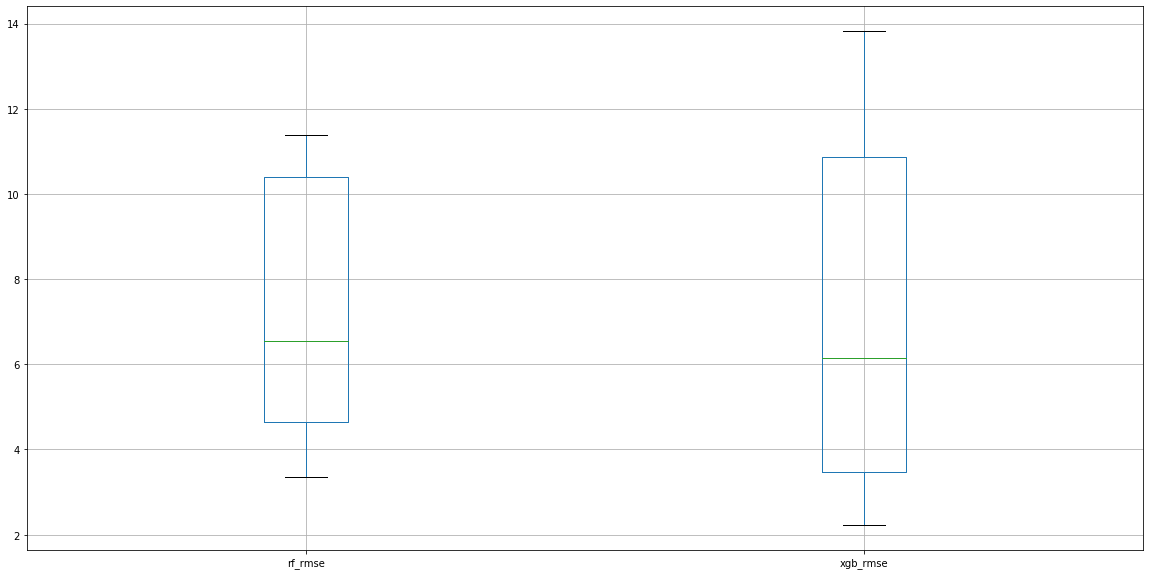

In [240]:
dv_plot = def_result.boxplot(figsize=(20,10))
dv_plot

## - Tunability of single hyperparameter

In [235]:
# Import results
rf_tune_one = pd.read_csv("rf_tune_one.csv")
xgb_tune_one = pd.read_csv("xgb_tune_one.csv")

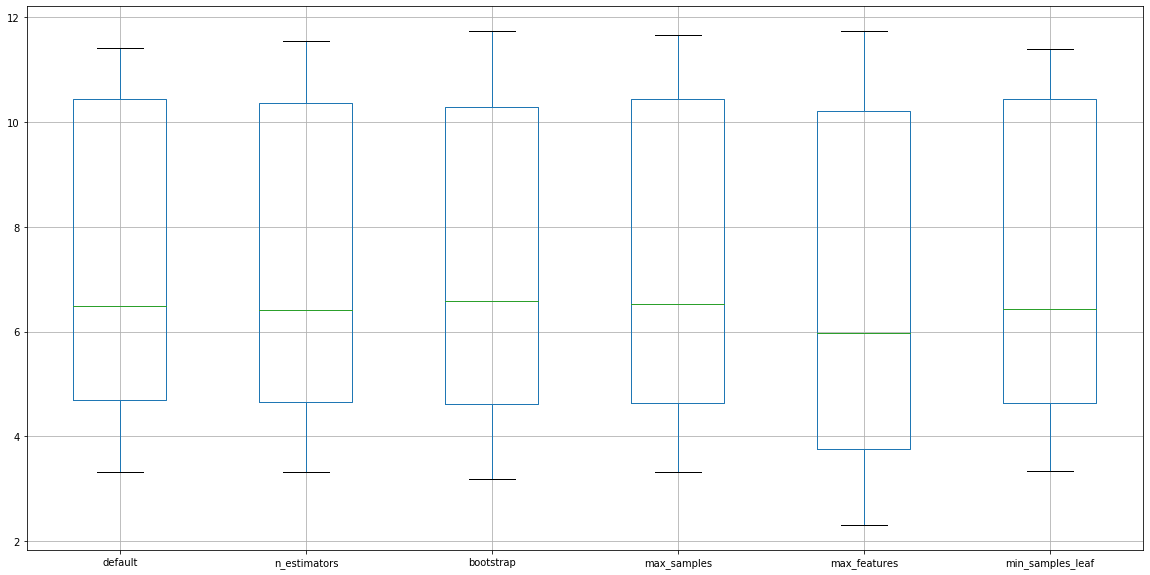

In [238]:
rf_tune_one.boxplot(figsize=(20,10))

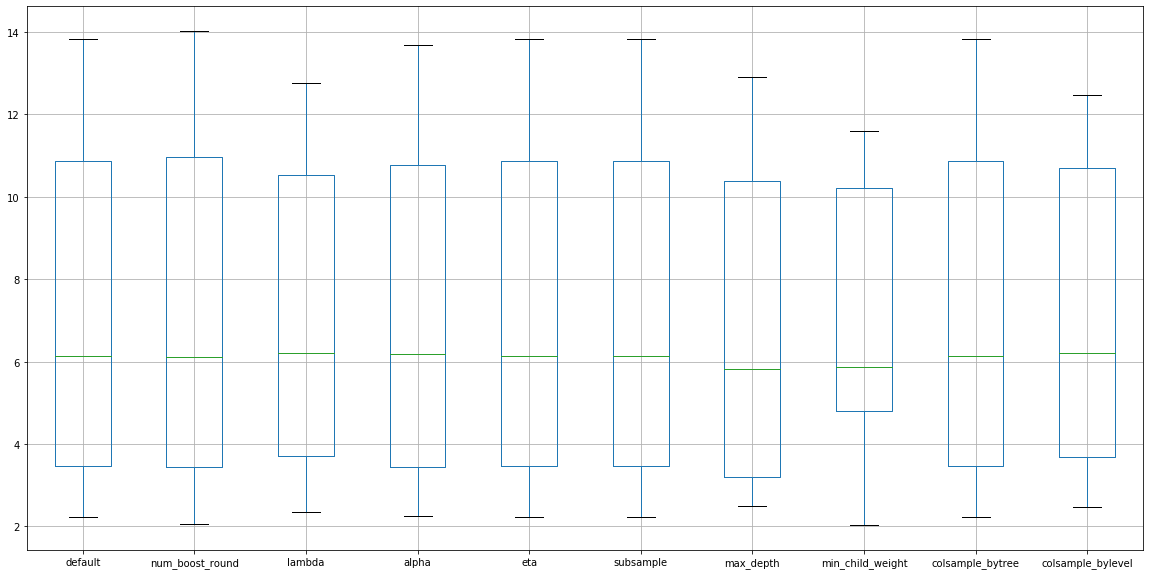

In [239]:
xgb_tune_one.boxplot(figsize=(20,10))

## - Random Forest using three methods

In [250]:
rdv = 7.188437947238364
xdv = 6.960065807407409

In [242]:
rf_grid_result = pd.read_csv("rf_grid_result.csv")
rf_rs_result = pd.read_csv("rf_rs_result.csv")
rf_bo_result = pd.read_csv("rf_bo_result.csv")

In [266]:
idx = rf_grid_result["value"].idxmin()
rf_grid_result.iloc[idx, :]

number                                                                     132
value                                                                  6.73054
datetime_start                                      2020-07-24 08:45:54.178549
datetime_complete                                   2020-07-24 09:25:45.755663
duration                                             0 days 00:39:51.577114000
params_bootstrap                                                          True
params_max_features                                                       auto
params_max_samples                                                        0.99
params_min_samples_leaf                                                      1
params_n_estimators                                                       1000
system_attrs_grid_id                                                       335
system_attrs_search_space    OrderedDict([('bootstrap', [False, True]), ('m...
state                                               

In [267]:
imp = (rdv-rf_grid_result.iloc[idx, :][1])/rdv
print("The improvement rate: {}".format(imp))

The improvement rate: 0.063699540720743


In [261]:
idx = rf_rs_result["value"].idxmin()
rf_rs_result.iloc[idx, :]

number                                             91
value                                         6.57085
datetime_start             2020-07-24 20:28:31.945827
datetime_complete          2020-07-24 20:46:56.664552
duration                    0 days 00:18:24.718725000
params_bootstrap                                 True
params_max_features                              auto
params_max_samples                                0.9
params_min_samples_leaf                             1
params_n_estimators                              1000
state                                        COMPLETE
Name: 91, dtype: object

In [262]:
imp = (rdv-rf_rs_result.iloc[idx, :][1])/rdv
print("The improvement rate: {}".format(imp))

The improvement rate: 0.08591444350571946


In [263]:
idx = rf_bo_result["value"].idxmin()
rf_bo_result.iloc[idx, :]

number                                             89
value                                         6.59018
datetime_start             2020-07-25 15:15:51.100678
datetime_complete          2020-07-25 15:23:45.914445
duration                    0 days 00:07:54.813767000
params_bootstrap                                 True
params_max_features                              auto
params_max_samples                                0.7
params_min_samples_leaf                             1
params_n_estimators                               500
state                                        COMPLETE
Name: 89, dtype: object

In [264]:
imp = (rdv-rf_bo_result.iloc[idx, :][1])/rdv
print("The improvement rate: {}".format(imp))

The improvement rate: 0.08322556583538303


## - XGBoost using three methods

In [246]:
xgb_grid_result = pd.read_csv("xgb_grid_result.csv")
xgb_rs_result = pd.read_csv("xgb_rs_result.csv")
xgb_bo_result = pd.read_csv("xgb_bo_result.csv")

In [268]:
idx = xgb_grid_result["value"].idxmin()
xgb_grid_result.iloc[idx, :]

number                                                                     137
value                                                                   6.6243
datetime_start                                      2020-07-24 06:41:10.704274
datetime_complete                                   2020-07-24 06:41:14.650843
duration                                             0 days 00:00:03.946569000
params_alpha                                                                 1
params_colsample_bytree                                                      1
params_lambda                                                                1
params_max_depth                                                            10
params_min_child_weight                                                     64
params_num_boost_round                                                      10
system_attrs_grid_id                                                       456
system_attrs_search_space    OrderedDict([('alpha', 

In [269]:
imp = (xdv-xgb_grid_result.iloc[idx, :][1])/xdv
print("The improvement rate: {}".format(imp))

The improvement rate: 0.048242034288811846


In [270]:
idx = xgb_rs_result["value"].idxmin()
xgb_rs_result.iloc[idx, :]

number                                              81
value                                          6.61093
datetime_start              2020-07-25 02:25:24.526967
datetime_complete           2020-07-25 02:26:12.504942
duration                     0 days 00:00:47.977975000
params_alpha                                         0
params_colsample_bylevel                           0.1
params_colsample_bytree                            0.9
params_eta                                         0.2
params_lambda                                     1024
params_max_depth                                    10
params_min_child_weight                             32
params_num_boost_round                             440
params_subsample                                   0.9
state                                         COMPLETE
Name: 81, dtype: object

In [271]:
imp = (xdv-xgb_rs_result.iloc[idx, :][1])/xdv
print("The improvement rate: {}".format(imp))

The improvement rate: 0.050162381180721305


In [272]:
idx = xgb_bo_result["value"].idxmin()
xgb_bo_result.iloc[idx, :]

number                                              99
value                                          6.50044
datetime_start              2020-07-25 04:04:29.370426
datetime_complete           2020-07-25 04:04:52.142324
duration                     0 days 00:00:22.771898000
params_alpha                                         4
params_colsample_bylevel                           0.2
params_colsample_bytree                              1
params_eta                                         0.1
params_lambda                                      256
params_max_depth                                     1
params_min_child_weight                              8
params_num_boost_round                             390
params_subsample                                     1
state                                         COMPLETE
Name: 99, dtype: object

In [273]:
imp = (xdv-xgb_bo_result.iloc[idx, :][1])/xdv
print("The improvement rate: {}".format(imp))

The improvement rate: 0.06603718425463458
